In [343]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
from unidecode import unidecode
from tqdm import tqdm
import json
import re
from IPython.display import HTML

<style>
	h3{
		background-color: orange;
		color: black;
		text-align: center;
		border: 2px solid red;
			font-weight: bolder;
	}
</style>
<h3>Importar datos de tabla a analizar</h3>

In [344]:
#funciones dix

wb_df_original_file = './Cambios_aplicados/wb_df_original_file.xlsx'
wb_df_final_file = './Cambios_aplicados/wb_df_final_file.xlsx' 

def save_df_changes(df_object, file_name='Libro_cambios_aplicados'):
  try:
    df_object.to_excel(f'./Cambios_aplicados/{file_name}.xlsx', index=None)
    print(f'Se ha exportado el libro: {file_name}.xlsx\nRuta del archivo: "Cambios_aplicados -> {file_name}.xlsx"')
  except PermissionError:
    print("el libro no se pudo exportar, debido a que el libro exportado anteriormente esta abierto, se debe cerrar.")
    
def sin_ascentos(nombre: str)-> str:
  abc = [
    ('Á', 'A'), ('É', 'E'), ('Í', 'I'), ('Ó', 'O'), ('Ú', 'U'), ('Ü', 'U'), 
    ('á', 'a'), ('é', 'e'), ('í', 'i'), ('ó', 'o'), ('ú', 'u'), ('ü', 'u')
    ]
  for a in abc:
    nombre = nombre.replace(a[0], a[1])
  return nombre

def save_df_in_sheet_from_workbook(dataframe, sheetname, workbookname):
  """
  Save a DataFrame into an Excel worksheet inside a specified Excel file.

  Arguments:
  - dataframe: The DataFrame to be saved into the Excel worksheet
  - sheetname: The name of the Excel worksheet in which the DataFrame will be written
  - workbookname: The name of the Excel file in which the DataFrame will be saved
  """
  try:
    with pd.ExcelWriter(workbookname, mode='a') as writer:
      dataframe.to_excel(writer, sheet_name=sheetname, index=None)
  except FileNotFoundError:
    with pd.ExcelWriter(workbookname) as writer:
      dataframe.to_excel(writer, sheet_name=sheetname, index=None)

In [345]:
# variables files
file_p = './Sitios SEMS.xlsx'

In [346]:
# # carga de archivo y eliminar el index 0 y 1
# data = pd.read_excel(io = file_p, sheet_name=0, names=col_names)
# data.drop(index=[0,1], inplace=True)

# cargar en memoria el archivo de excel
data = pd.read_excel(io=file_p, sheet_name=0, dtype={'Código postal*': object})

# CREAR DATAFRAME
df = pd.DataFrame(data)

In [347]:
sh = df.shape
print(f'El archivo tiene {sh[0]} filas y {sh[1]} columnas')

El archivo tiene 1666 filas y 24 columnas


<style>
	h3{
		background-color: orange;
		color: black;
		text-align: center;
		border: 2px solid red;
			font-weight: bolder;
	}
</style>
<h3>Columnas Clave Dependencia (1) y Dependencia (2) </h3>

In [348]:
tRamos = pd.read_csv('./Compact_inegi_dbLocs/ramo.csv')
lst_ramos = tRamos["cve_ramo"].to_list()
lst_desc_ramos = tRamos['descripcion'].to_list()
dictRamosByID = dict(zip(lst_ramos, lst_desc_ramos))
dictRamosByDesc = dict(zip(lst_desc_ramos, lst_ramos))

In [349]:
# solo analizar si existe una clave de dependecia (ramo) 
for x in df['Clave de la Dependencia*'].items():
  xI, xV = x[0], x[1]
  
  clv = df['Clave de la Dependencia*'].iloc[xI]
  dep = df['Dependencia*'].iloc[xI]
  
  #si la clave existe en la lista pero no es el mismo valor que hay el el diccionario que se haga la corrección
  if clv in lst_ramos and dictRamosByID[clv] != dep:
    df.iloc[xI,[1]] = dictRamosByID[clv]
  
  # si la clave no esta en la lista
  if clv  not in lst_ramos:
    if clv != " " or clv != "":
      try:
        df.iloc[xI,[0]] = dictRamosByDesc[dep]
        df.iloc[xI, [1]] = dictRamosByID[clv]
      except KeyError:
        df.iloc[xI,[0]] = " "
  

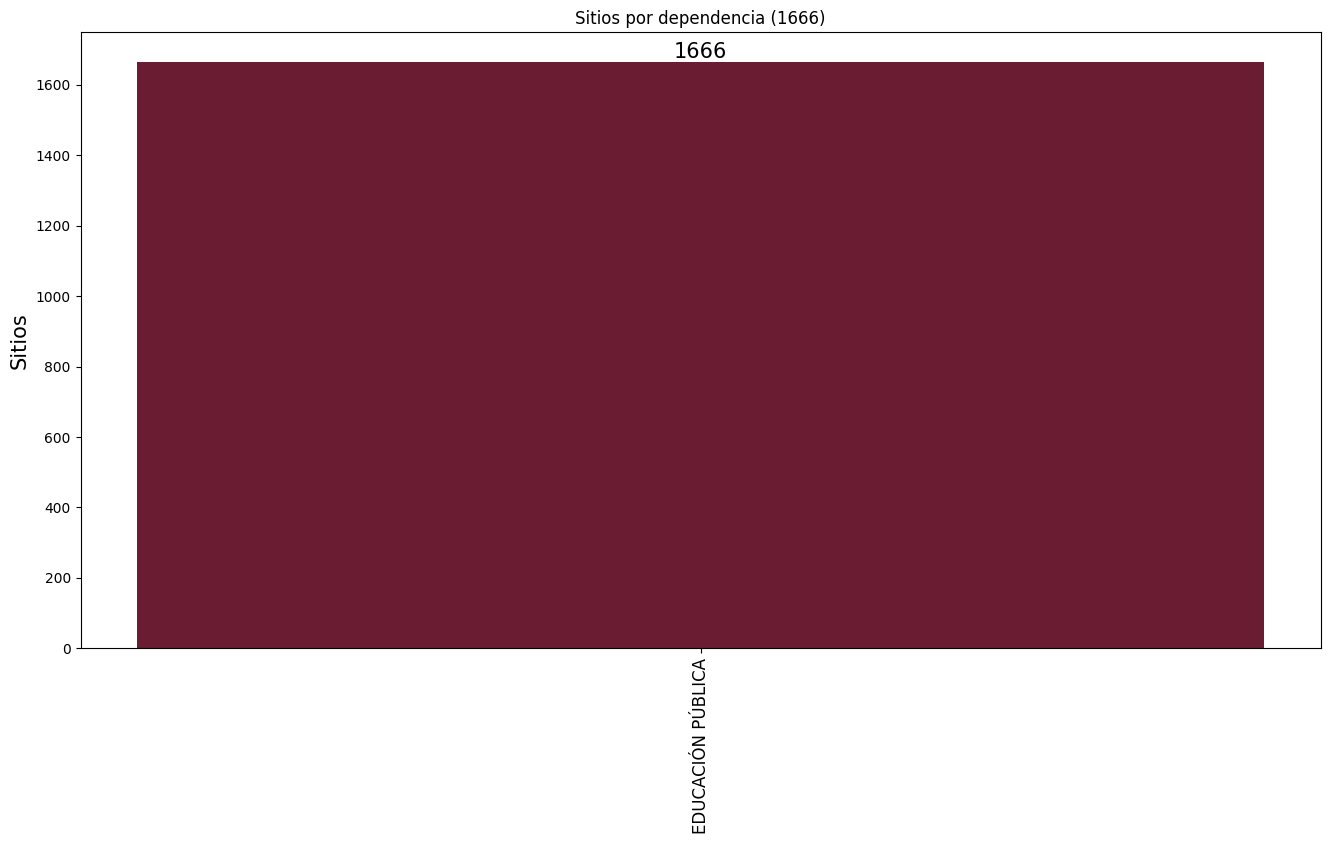

In [350]:
# conteo_regs_por_edo = df.groupby(by="Estado*").agg(conteo_regs=('Estado*', 'count')).reset_index().sort_values(by="conteo_regs", ascending=False)
# total_regs = conteo_regs_por_edo['conteo_regs'].sum()

df_group_dependencia = df.groupby(by="Dependencia*").agg(conteo_regs=('Dependencia*', 'count')).reset_index().sort_values(by='conteo_regs', ascending=False)
ttl_df_group_dependencia = df_group_dependencia['conteo_regs'].sum()

# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(16, 8))

# Crear un gráfico de barras
ax.bar( df_group_dependencia['Dependencia*'], df_group_dependencia['conteo_regs'], width=0.75, color='#691C32')

# Agregar etiquetas a las barras
for x in ax.containers:
    ax.bar_label(x, label_type='edge', fontsize=15)
    

# Establecer los títulos y etiquetas de los ejes
ax.set_title(f'Sitios por dependencia ({ttl_df_group_dependencia})')
# ax.set_xlabel('Dependencias', fontsize=15)
ax.set_ylabel('Sitios', fontsize=15)

# Cambiar las etiquetas del eje x
ax.xaxis.set_major_locator(FixedLocator(range(len(df_group_dependencia))))
ax.xaxis.set_major_formatter(FixedFormatter(df_group_dependencia['Dependencia*']))

ax.set_xticklabels(labels=df_group_dependencia['Dependencia*'],fontsize=12)

# Girar las etiquetas del eje x
ax.tick_params(axis='x', labelrotation=90)

plt.show()


#eliminación de variables:
try:
    save_df_in_sheet_from_workbook(df_group_dependencia, 'gb_dependencia', wb_df_original_file) 
    del tRamos
except NameError:
    pass


<style>
	h3{
		background-color: orange;
		color: black;
		text-align: center;
		border: 2px solid red;
			font-weight: bolder;
	}
</style>
<h3>Columna Clave de inmueble (3) </h3>

In [351]:
conteo_por_clvs = df.groupby(by='Clave del inmueble*').agg(regs_por_clave=('Clave del inmueble*', 'count')).reset_index()
conteo_por_clvs_duplicadas_clv =  conteo_por_clvs[conteo_por_clvs['regs_por_clave'] > 1].reset_index()
regs_sin_clv = conteo_por_clvs_duplicadas_clv[conteo_por_clvs_duplicadas_clv['Clave del inmueble*'] == " "]['regs_por_clave'][0]
regs_clv_dupl = conteo_por_clvs_duplicadas_clv[conteo_por_clvs_duplicadas_clv['Clave del inmueble*'] != " "]['regs_por_clave'].sum()

print(f'Registros SIN clave asignada: {regs_sin_clv}\nRegistros clave DUPLICADA: {regs_clv_dupl}\nTotal registros: {regs_sin_clv + regs_clv_dupl}')

Registros SIN clave asignada: 26
Registros clave DUPLICADA: 34
Total registros: 60


In [352]:
conteo_por_clvs_duplicadas_clv = conteo_por_clvs_duplicadas_clv[['Clave del inmueble*','regs_por_clave']]
save_df_in_sheet_from_workbook(conteo_por_clvs_duplicadas_clv, 'count_clv_duplicates', wb_df_original_file)
conteo_por_clvs_duplicadas_clv

,Clave del inmueble*,regs_por_clave
0,,26
1,01DBT0028N,2
2,03DPT0001H,2
3,04INM0650E,2
4,06DPT0181F,2
5,07INM09313,2
6,09DBT0155B,2
7,09DBT0156A,2
8,09DBT0171T,2
9,11DBT0001N,2


In [353]:
# exportación de dataframe de registros duplicados en clave de inmueble
lst_dupli_clv = [x if x != " " and x != "" else None for x in conteo_por_clvs_duplicadas_clv['Clave del inmueble*'].to_list()]
df_regs_duplicados_by_clv = df[df['Clave del inmueble*'].isin(lst_dupli_clv)].sort_values(by='Clave del inmueble*')
# save_df_changes(df_regs_duplicados_by_clv, 'registros_duplicados_en_clave_inmueble')
save_df_in_sheet_from_workbook(df_regs_duplicados_by_clv, 'df_regs_dupli_in_file', wb_df_original_file)

In [354]:
try:
  del tRamos
  del lst_ramos
  del lst_desc_ramos
  del dictRamosByID
  del dictRamosByDesc
except NameError:
  pass
  

<style>
	h3{
		background-color: orange;
		color: black;
		text-align: center;
		border: 2px solid red;
		font-weight: bolder;
	}
</style>
<h3>Columna Tipo de inmuebles (5) </h3>

In [355]:
# importar catálogo de tipo de inmueble
tTipoInmueble = pd.read_csv('./Compact_inegi_dbLocs/tipo_inmueble.csv')
lstTipoInmueble = tTipoInmueble['tipo_inmueble'].to_list()

In [356]:
#asignar valor a la dependencia en caso de tener clave que su id este en la tabla de tipo de inmueble
for r in df['Tipo de inmuebles *'].items():
  rI, rV = r[0], r[1]
  cellClvDep = df['Clave de la Dependencia*'].iloc[rI]
  cellDep = df['Dependencia*'].iloc[rI]
  
  if cellClvDep == 11 and cellDep == "EDUCACIÓN PÚBLICA":
    df.at[rI, 'Tipo de inmuebles *'] = 'ESTABLECIMIENTO DE EDUCACIÓN'


In [357]:
#eliminación de table variable 
try:
  del tTipoInmueble
  del lstTipoInmueble
except NameError:
  pass

<style>
	h3{
		background-color: orange;
		color: black;
		text-align: center;
		border: 2px solid red;
		font-weight: bolder;
	}
</style>
<h3>Columna Subtipo de Inmueble (6) </h3>

In [358]:
#import catálogo de subtipos de inmueble
tSubtipoInmueble = pd.read_csv('./Compact_inegi_dbLocs/subtipo_inmueble.csv')
#tSubtipoInmueble[tSubtipoInmueble['descripcion'].str.contains('EDUCACIÓN')]

In [359]:
# cambio o modificación de nombres en el campo de nombre del inmueble 
# lTemporal = []
for x in df['Subtipo de inmueble *'].items():
  xI, xV = x[0], x[1]
  cellNombreInmueble = df['Nombre del inmueble*'].iloc[xI]
  cellSubtipoInmueble = df['Subtipo de inmueble *'].iloc[xI]
  reasignarValor_NombreDelInmueble = df.at[xI, 'Nombre del inmueble*']
  
  if cellSubtipoInmueble == 'COLEGIO DE EDUCACIÓN PROFESIONAL TÉCNICA (CONALEP)':
    concatenado = f'{cellSubtipoInmueble} {cellNombreInmueble}'
    reasignarValor_NombreDelInmueble = concatenado
    
  elif cellSubtipoInmueble == 'CENTRO DE BACHILLERATO TECNOLÓGICO AGROPECUARIO (CBTA)':
    reasignarValor_NombreDelInmueble = f'CENTRO DE BACHILLERATO TECNOLÓGICO AGROPECUARIO - {cellNombreInmueble}'
  
  elif cellSubtipoInmueble == 'EXTENSIÓN (CBTA)':
    reasignarValor_NombreDelInmueble = f'EXTENSIÓN {cellNombreInmueble}'
  
  elif cellSubtipoInmueble == 'OFICINA ADMINISTRATIVA':
    reasignarValor_NombreDelInmueble = f'{cellNombreInmueble} (Oficina administrativa)'
  
  elif cellSubtipoInmueble == 'CENTRO DE ESTUDIOS TECNOLÓGICOS DEL MAR (CETMAR)':
    reasignarValor_NombreDelInmueble = f'CENTRO DE ESTUDIOS TECNOLÓGICOS DEL MAR - {cellNombreInmueble}'
  
  elif cellSubtipoInmueble == 'CENTRO DE ESTUDIOS DE BACHILLERATO (CEB)':
    reasignarValor_NombreDelInmueble = f'CENTRO DE ESTUDIOS DE BACHILLERATO - {cellNombreInmueble}'
  
  elif cellSubtipoInmueble == 'CENTRO DE ESTUDIOS TECNOLÓGICOS EN AGUAS CONTINENTALES (CETAC)':
    reasignarValor_NombreDelInmueble = f'CENTRO DE ESTUDIOS TECNOLÓGICOS EN AGUAS CONTINENTALES - {cellNombreInmueble}'
  
  elif cellSubtipoInmueble == 'EXTENSIÓN (CETMAR)':
    reasignarValor_NombreDelInmueble = f'EXTENSIÓN {cellNombreInmueble}'
  
  elif cellSubtipoInmueble == 'CENTRO DE BACHILLERATO TECNOLÓGICO FORESTAL (CBTF)':
    reasignarValor_NombreDelInmueble = f'CENTRO DE BACHILLERATO TECNOLÓGICO FORESTAL - {cellNombreInmueble}'
    
  elif cellSubtipoInmueble == 'COLEGIO DE EDUCACIÓN PROFESIONAL TÉCNICA DEL ESTADO DE TLAXCALA (CONALEP)':
    reasignarValor_NombreDelInmueble = f'COLEGIO DE EDUCACIÓN PROFESIONAL TÉCNICA DEL ESTADO DE TLAXCALA - {cellNombreInmueble}'
  
  elif cellSubtipoInmueble == 'EXTENSIÓN CBTA' or cellSubtipoInmueble == 'EXTENSIÓN (CBTF)':
    reasignarValor_NombreDelInmueble = f'EXTENSIÓN - {cellNombreInmueble}'
  
  elif cellSubtipoInmueble == 'UNIDADES DE CAPACITACIÓN PARA EL DESARROLLO RURAL (UNCADER)':
    reasignarValor_NombreDelInmueble = f'UNIDADES DE CAPACITACIÓN PARA EL DESARROLLO RURAL - {cellNombreInmueble}'
  
  elif 'CENTRO DE ESTUDIOS TECNOLÓGICOS INDUSTRIAL Y DE SERVICIOS' in cellSubtipoInmueble:
    reasignarValor_NombreDelInmueble = f'CENTRO DE ESTUDIOS TECNOLÓGICOS INDUSTRIAL Y DE SERVICIOS -  {cellNombreInmueble}'
  
  elif 'CENTRO DE BACHILLERATO TECNOLÓGICO INDUSTRIAL Y DE SERVICIOS' in cellSubtipoInmueble:
    reasignarValor_NombreDelInmueble = f'CENTRO DE BACHILLERATO TECNOLÓGICO INDUSTRIAL Y DE SERVICIOS - {cellNombreInmueble}'
  
  elif cellSubtipoInmueble in ['CENTRO DE BACHILLERATO TECNOLÓGICO AGROPECUARIO No. 167', 'EXTENSIÓN (CETAC)', 'COLEGIO DE EDUCACIÓN PROFESIONAL TÉCNICA (CONALEP)  ', 'COLEGIO DE EDUCACIÓN PROFESIONAL TÉCNICA  DEL ESTADO DE TLAXCALA (CONALEP)', 'CENTRO MULTIMODAL DE ESTUDIOS CIENTIFICOS Y TECNOLOGICOS DEL MAR Y AGUAS CONTINENTALES', 'CENTRO DE INVESTIGACION DE RECURSOS NATURALES (CIRENA)', 'CENTRO DE BACHILLERATO TECNOLOGICO AGROPECUARIO NUM 191']:
    reasignarValor_NombreDelInmueble =f'{cellSubtipoInmueble} - {cellNombreInmueble}'
    

#eliminación de tabla variable
try:
  del tSubtipoInmueble
except NameError:
  pass

In [360]:
dict_subtp_inmueble = [
	{
   'PLANTEL EDUCACIÓN MEDIA SUPERIOR': [
     'Bachillerato Tecnológico de Educación y Promoción Deportiva', 'CENTRO DE BACHILLERATO TECNOLÓGICO AGROPECUARIO', 'CENTRO DE BACHILLERATO TECNOLÓGICO FORESTAL', 'CENTRO DE BACHILLERATO TECNOLÓGICO INDUSTRIAL Y DE SERVICIOS', 'CENTRO DE CAPACITACIÓN PARA EL TRABAJO INDUSTRIAL', 'CENTRO DE ENSEÑANZA TÉCNICA INDUSTRIAL', 'CENTRO DE ESTUDIOS DE BACHILLERATO', 'CENTRO DE ESTUDIOS TECNOLÓGICOS DEL MAR', 'CENTRO DE ESTUDIOS TECNOLÓGICOS EN AGUAS CONTINENTALES', 'CENTRO DE ESTUDIOS TECNOLÓGICOS INDUSTRIAL Y DE SERVICIOS', 'CENTRO DE INVESTIGACION DE RECURSOS NATURALES', 'CENTRO MULTIMODAL DE ESTUDIOS CIENTIFICOS Y TECNOLOGICOS DEL MAR Y AGUAS CONTINENTALES', 'COLEGIO DE BACHILLERES', 'COLEGIO DE EDUCACIÓN PROFESIONAL TÉCNICA', 'COLEGIO DE EDUCACIÓN PROFESIONAL TÉCNICA DEL ESTADO DE TLAXCALA', '(CBTA)', '(CBTF)', '(CETAC)', '(CETMAR)', 'UNIDADES DE CAPACITACIÓN PARA EL DESARROLLO RURAL', 'EXTENSIÓN CBTA', 'EXTENSIÓN (CBTA)', 'EXTENSIÓN (CBTF)', 'EXTENSIÓN (CETAC)', 'EXTENSIÓN (CETMAR)', 'CENTRO DE ESTUDIOS DE BACHILLERATO (CEB)', 'CENTRO DE ENSEÑANZA TÉCNICA INDUSTRIAL (CETI)', 'CENTRO DE ESTUDIOS TECNOLÓGICOS DEL MAR (CETMAR)', 'COLEGIO DE EDUCACIÓN PROFESIONAL TÉCNICA (CONALEP)', 'CENTRO DE BACHILLERATO TECNOLÓGICO FORESTAL (CBTF)', 'COLEGIO DE EDUCACIÓN PROFESIONAL TÉCNICA (CONALEP)  ', 'CENTRO DE BACHILLERATO TECNOLÓGICO AGROPECUARIO (CBTA)', 'CENTRO DE INVESTIGACION DE RECURSOS NATURALES (CIRENA)', 'CENTRO DE BACHILLERATO TECNOLOGICO AGROPECUARIO', 'CENTRO DE BACHILLERATO TECNOLÓGICO AGROPECUARIO', 'CENTRO DE CAPACITACIÓN PARA EL TRABAJO INDUSTRIAL (CECATI)', 'UNIDADES DE CAPACITACIÓN PARA EL DESARROLLO RURAL (UNCADER)', 'CENTRO DE ESTUDIOS TECNOLÓGICOS EN AGUAS CONTINENTALES (CETAC)', 'CENTRO DE ESTUDIOS TECNOLÓGICOS INDUSTRIAL Y DE SERVICIOS', 'CENTRO DE BACHILLERATO TECNOLÓGICO INDUSTRIAL Y DE SERVICIOS', 'COLEGIO DE EDUCACIÓN PROFESIONAL TÉCNICA DEL ESTADO DE TLAXCALA', 'COLEGIO DE EDUCACIÓN PROFESIONAL TÉCNICA  DEL ESTADO DE TLAXCALA', 'CENTRO DE BACHILLERATO TECNOLÓGICO INDUSTRIAL Y DE SERVICIOS No. 57 - Extensión', 'CENTRO DE BACHILLERATO TECNOLÓGICO INDUSTRIAL Y DE SERVICIOS No. 2 - Ext.', 'CENTRO DE ESTUDIOS TECNOLÓGICOS INDUSTRIAL Y DE SERVICIOS No. 103 - Ext.', 'CENTRO DE ESTUDIOS TECNOLÓGICOS INDUSTRIAL Y DE SERVICIOS No. 124 - Ext.', 'CENTRO DE BACHILLERATO TECNOLÓGICO INDUSTRIAL Y DE SERVICIOS No. 3 - Ext.', 'COLEGIO DE EDUCACIÓN PROFESIONAL TÉCNICA DEL ESTADO DE TLAXCALA (CONALEP)', 'COLEGIO DE EDUCACIÓN PROFESIONAL TÉCNICA  DEL ESTADO DE TLAXCALA (CONALEP)', 'CENTRO DE BACHILLERATO TECNOLOGICO AGROPECUARIO NUM 191', 'CENTRO DE BACHILLERATO TECNOLÓGICO AGROPECUARIO No. 167'
     ]
  }
]

In [361]:
lst_general_concepts_tuplas = []

for ele in dict_subtp_inmueble:
  for key in ele.keys():
    for x in ele[key]:
      lst_temporal = [ [f'{x}'.title(), key], [f'{x}'.upper(), key], [f'{x}'.lower(), key], 
                      [x, key], [f'{sin_ascentos(x)}'.title(), key], [f'{sin_ascentos(x)}'.upper(), key], 
                      [f'{sin_ascentos(x)}'.lower(), key], [sin_ascentos(x), key] ]
      for l in lst_temporal:
        lst_general_concepts_tuplas.append(tuple(l))

lst_unicos_general_tuplas = set(lst_general_concepts_tuplas)
lst_unicos_conceptos = set([x[0] for x in lst_unicos_general_tuplas])


In [362]:
for x in df['Subtipo de inmueble *'].items():
  xI, xV = x[0], x[1]
  srt90 = round(len(xV)*.85)
  buscar = f'{xV[:srt90]}'.strip()
  temp_word = None
  minimo = 50
  if xV in lst_unicos_conceptos:
    for ele in lst_unicos_general_tuplas:
        if ele[0] == xV:
          temp_word = ele[1]
          break
    df.at[xI, 'Subtipo de inmueble *'] = temp_word
    # print(xV, " | ", temp_word, " <- primer bucle")
  else:
    if len(xV) > minimo:
      for x in lst_unicos_conceptos:
        if buscar in x:
          temp_word = x
          for l in lst_unicos_general_tuplas:
            if temp_word ==  l[0]:
              temp_word = l[1]
              # print(xV, " | ", temp_word, "<- segundo bucle")
              df.at[xI, 'Subtipo de inmueble *'] = temp_word
              break

In [363]:
# conteo de registros por subtipos de inmuebles 
conteo_subtipo_inmueble = df.groupby(by='Subtipo de inmueble *').agg(conteo_regs=('Subtipo de inmueble *', 'count')).reset_index()
ordenado_conteo_subtipo_inmueble = conteo_subtipo_inmueble.sort_values(by='conteo_regs', ascending=False)
save_df_in_sheet_from_workbook(ordenado_conteo_subtipo_inmueble, 'count_by_sbtp_inmueb', wb_df_original_file)
ordenado_conteo_subtipo_inmueble

,Subtipo de inmueble *,conteo_regs
1,PLANTEL EDUCACIÓN MEDIA SUPERIOR,1609
0,OFICINA ADMINISTRATIVA,57


In [364]:
try:
  del tSubtipoInmueble
except NameError:
  pass

<style>
	h3{
		background-color: orange;
		color: black;
		text-align: center;
		border: 2px solid red;
	}
</style>
<h3>Columna Estado (8) </h3>

In [365]:
tEdosMunLoc = pd.read_csv(filepath_or_buffer= './Compact_inegi_dbLocs/AGEEML_20233271140141.csv', encoding='utf-8')

l_idEdo, l_edos = list(tEdosMunLoc['CVE_ENT'].unique()),list(tEdosMunLoc['NOM_ENT'].unique())

l_id_edos = list(zip(l_edos, l_idEdo))
l_id = list(zip(l_idEdo, l_edos))

dict_edos = dict(l_id_edos)
dict_ids = dict(l_id)

In [366]:
# homologar nombres de estados con base en catálogo inegi
col_temp_edos = []
col_temp_idEdos = []
edos_no_loc = []
for r in df['Estado*'].items():
  rI, rV = r[0], r[1]
  col_temp_edos.append(f'{rV}'.title().strip())

for rEdo in col_temp_edos:
  if rEdo in l_edos:
    col_temp_idEdos.append(dict_edos[rEdo])
  else:
    
    if rEdo in ['Ciudad De México', 'Ciudad De Mexico']:
      col_temp_idEdos.append(dict_edos['Ciudad de México'])
    
    elif rEdo in ['Estado De Mexico','Estado De México', 'M\x90Éxico']:
      col_temp_idEdos.append(dict_edos['México'])
    
    elif rEdo in ['Coahuila', 'Coahuila De Zaragoza']:
      col_temp_idEdos.append(dict_edos['Coahuila de Zaragoza'])
    
    elif rEdo in ["Michoacán De Ocampo", 'Michoacán']:
      col_temp_idEdos.append(dict_edos['Michoacán de Ocampo'])
    
    elif rEdo in ['Quer\x90Étaro', 'Querétaro De Arteaga']:
      col_temp_idEdos.append(dict_edos['Querétaro'])
    
    elif rEdo in ['San Luis Potosi']:
      col_temp_idEdos.append(dict_edos['San Luis Potosí'])
    
    elif rEdo in ['Veracruz', 'Veracruz De Ignacio De La Llave', 'Veracruz Llave']:
      col_temp_idEdos.append(dict_edos['Veracruz de Ignacio de la Llave'])
    
    elif rEdo == '':
      col_temp_idEdos.append('INFO. SIN DEFINIR')

    else:
      edos_no_loc.append(rEdo)

# print(f'Elementos en col edos: {len(col_temp_edos)}\nElementos en col id edos {len(col_temp_idEdos)}\nElementos no locs: {len(edos_no_loc)}')
#set(edos_no_loc)

#col_temp_idEdos

In [367]:
#agregar una columna a mi df (id edos)
df.insert(7, 'id_edo', col_temp_idEdos)


In [368]:
# reasignar valor en la columna de nombres de estados para homologar valores
for x in df['Estado*'].items():
  xI, xV = x[0], x[1]
  idEdo = df['id_edo'].iloc[xI]
  if idEdo != 'INFO. SIN DEFINIR':
    df.at[xI, 'Estado*'] = dict_ids[idEdo]
  else:
    df.at[xI, 'Estado*'] = 'INFO. SIN DEFINIR'


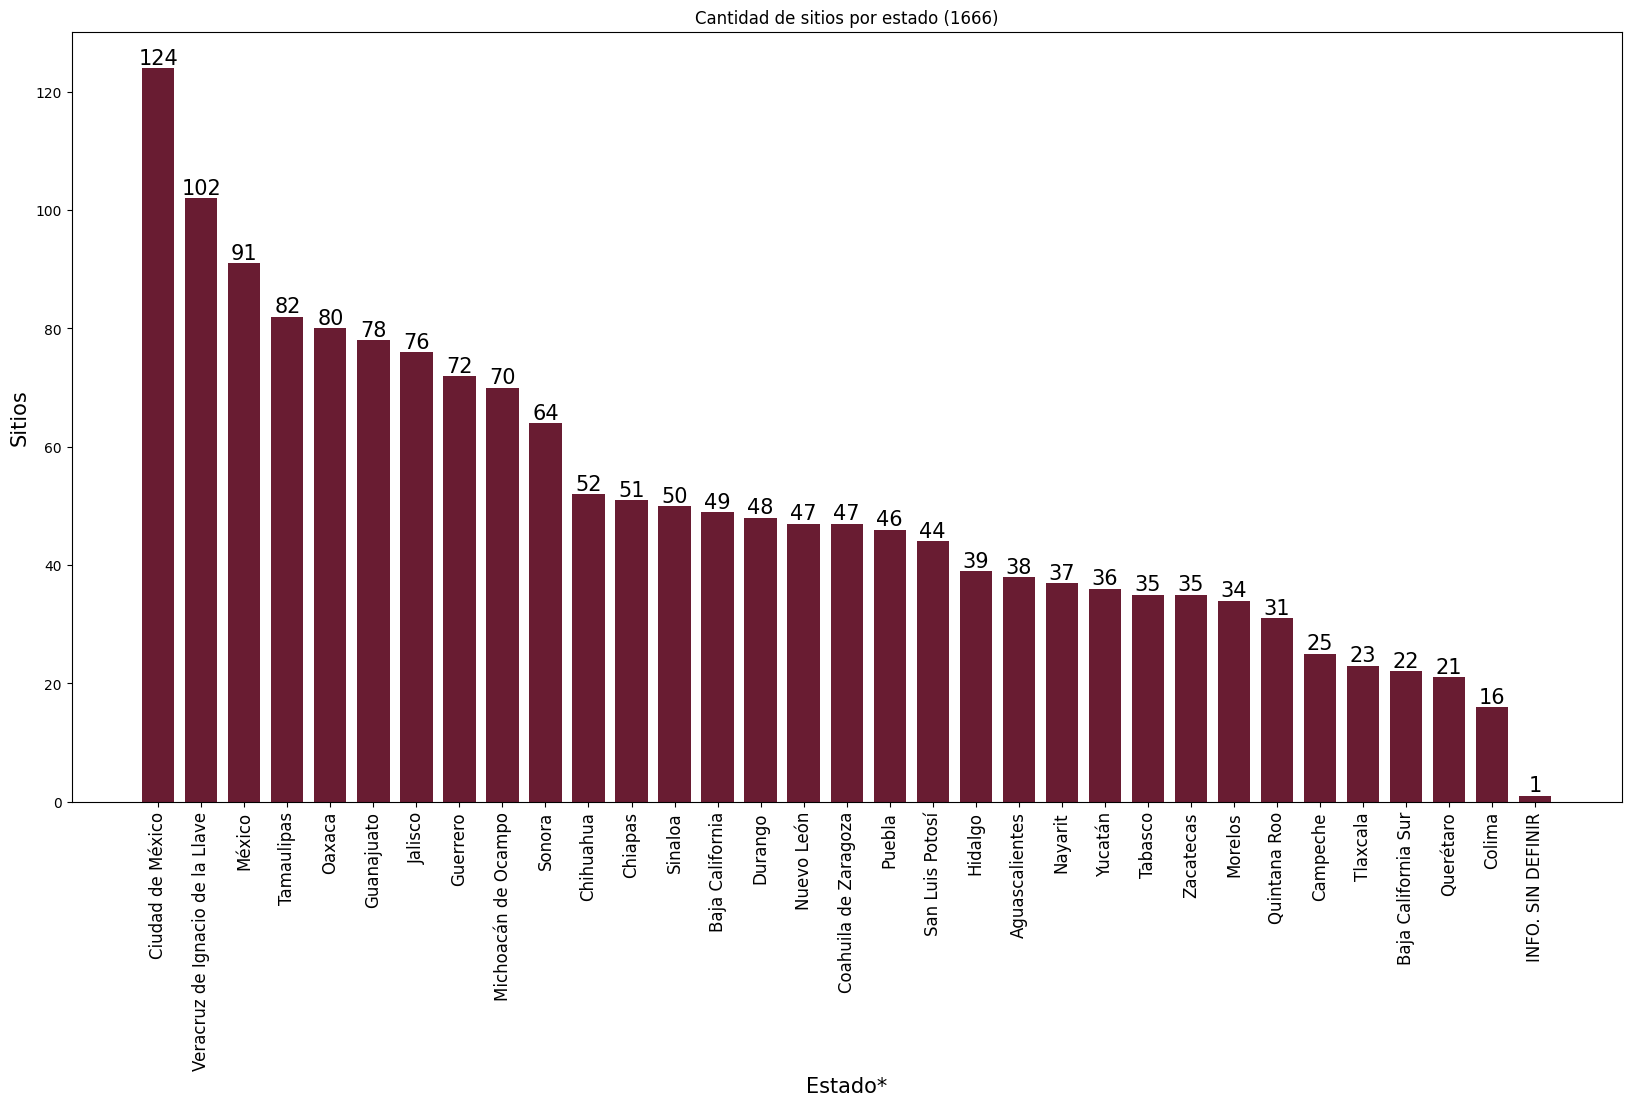

In [369]:
#crear gráfica de cuantos sitios hay por estado
conteo_regs_por_edo = df.groupby(by="Estado*").agg(conteo_regs=('Estado*', 'count')).reset_index().sort_values(by="conteo_regs", ascending=False)
total_regs = conteo_regs_por_edo['conteo_regs'].sum()

save_df_in_sheet_from_workbook(conteo_regs_por_edo, 'count_regs_by_edo', wb_df_original_file)

# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(20, 10))

# Crear un gráfico de barras
ax.bar( conteo_regs_por_edo['Estado*'], conteo_regs_por_edo['conteo_regs'], width=0.75, color='#691C32')

# Agregar etiquetas a las barras
for x in ax.containers:
    ax.bar_label(x, label_type='edge', fontsize=15)

# Establecer los títulos y etiquetas de los ejes
ax.set_title(f'Cantidad de sitios por estado ({total_regs})')
ax.set_xlabel('Estado*', fontsize=15)
ax.set_ylabel('Sitios', fontsize=15)

# Cambiar las etiquetas del eje x
ax.xaxis.set_major_locator(FixedLocator(range(len(conteo_regs_por_edo))))
ax.xaxis.set_major_formatter(FixedFormatter(conteo_regs_por_edo['Estado*']))


# Cambiar las etiquetas del eje x
# abreviaturas_estados = ['BC', 'BCS', 'SON', 'CHI', 'SIN', 'COA', 'NAY', 'DGO', 'ZAC', 'AGS', 'JAL', 'COL', 'MIC', 'GRO', 'QUE', 'SLP', 'GTO', 'HID', 'PUE', 'MEX', 'CDMX', 'TLAX', 'MOR', 'VER', 'TAB', 'CAM', 'YUC', 'ROO', 'QROO']
# ax.set_xticklabels(abreviaturas_estados, fontsize=12)

ax.set_xticklabels(labels=conteo_regs_por_edo['Estado*'],fontsize=12)

# Girar las etiquetas del eje x
ax.tick_params(axis='x', labelrotation=90)

# Mostrar el gráfico
plt.show()



<style>
	h3{
		background-color: orange;
		color: black;
		text-align: center;
		border: 2px solid red;
	}
</style>
<h3>Columna Municipio (9) </h3>

In [370]:
def get_id_mun(idEdo: int, nomMunBuscar: str):
  l_mun = nomMunBuscar.strip().split(' ')
  l_len_mun_ele = list(sorted(l_mun, key=len))
  #para_busqueda = []
  l_mun_by_edo = list(set(tEdosMunLoc[tEdosMunLoc['CVE_ENT'] == idEdo]['NOM_MUN'].to_list()))

  resultado = None
  
  try:
    if len(l_len_mun_ele) > 1:
      biggest = l_len_mun_ele[-1]
      next_bigger = l_len_mun_ele[-2]
      
      for l_r in l_mun_by_edo:
        sin_ascento_l_r = unidecode(l_r)
        if biggest in l_r and next_bigger in l_r:
          resultado = l_r
          break
        elif biggest in sin_ascento_l_r and next_bigger in l_r:
          resultado = l_r
          break
      
    elif len(l_len_mun_ele) == 1:
      biggest = l_len_mun_ele[-1]
      
      for l_r in l_mun_by_edo:
        sin_ascento_l_r = unidecode(l_r)
        if biggest in l_r:
          resultado = l_r
          break
        elif biggest in sin_ascento_l_r:
          resultado = l_r
          break
      
    sub_filter = tEdosMunLoc[(tEdosMunLoc['CVE_ENT'] == idEdo) & (tEdosMunLoc['NOM_MUN'].str.contains(resultado))][['CVE_ENT','NOM_ENT', 'CVE_MUN', 'NOM_MUN']].drop_duplicates()
    f_resultado = tuple([sub_filter['CVE_MUN'].iloc[0], sub_filter['NOM_MUN'].iloc[0]])
    return f_resultado
  
  except Exception:
    return (0, '')



In [371]:
#df_edo_mun[df_edo_mun['CVE_ENT'] == 9]
edoMun = tEdosMunLoc[['CVE_ENT','NOM_ENT', 'CVE_MUN', 'NOM_MUN']]

def get_edu_mun_data(idEdo: int, munName: str) -> int:
  '''
  idEdo = entero id estado de la república\n
  munName = nombre municipio
  '''
  try:
    r = edoMun[(edoMun['CVE_ENT'] == idEdo) & (edoMun['NOM_MUN'] == munName)]['CVE_MUN'].iloc[0]
    return r
  except:
    return 0

In [372]:
#CREAR LISTAS  DE VALIDACIÓN A PARTIR DE LA INFO DESCARGADA DEL INEGI
unique_mun = list(edoMun['NOM_MUN'].drop_duplicates())
mun_sin_ascento = [unidecode(x) for x in unique_mun]
tupla_mun_sin_ascento = [(unidecode(x), x) for x in unique_mun]

In [373]:
# 
words_replace_mun = ['Delegación', 'Ciudad Del', 'Cd.', 'Ciudad de ', 'Ciudad ', 'Alcaldía ']
df['Municipio*'] = df['Municipio*'].str.title()
df['Municipio*'] = df['Municipio*'].str.strip()

for w in words_replace_mun:
  df['Municipio*'] = df['Municipio*'].str.replace(w, "", regex=False)

df['Municipio*'] = df['Municipio*'].str.strip()


In [374]:
# IMPORTANTE: primero limpia los nombres de los municipios
# for r in df['Municipio*'].items():
#   rI, rV = r[0], r[1]
#   if rV.split() != '':
#     df.at[rI, 'Municipio*'] = f'{rV}'.title().replace("Delegación", "").replace('Ciudad Del', '').replace("Cd.", "").replace('Ciudad de ', '').replace('Ciudad ', '').replace('Alcaldía ', '').strip()

for r in df['Municipio*'].items():
  # deconstrucción variables rI = index row, rV = cell value
  rI, rV = r[0], r[1]
  # idEdo = id del estado
  idEdo = df['id_edo'].iloc[rI]
  #*********************************************************
  # si valor de la celda está en la list de valores únicos de municipios
  if rV in unique_mun:
    for rowReg in tupla_mun_sin_ascento:
      if rowReg[0] == rV:
        df.loc[rI, 'Municipio*'] = f'{rowReg[1]}'
        break
  #*********************************************************
  # si el val  de la celda esta en la lista de municipios sin ascento 
  elif rV in mun_sin_ascento and rV not in unique_mun:
    for t in tupla_mun_sin_ascento:
      if rV == t[0]:
        df.loc[rI, 'Municipio*'] = t[1]
        break
  #*********************************************************
  # si val de la celda tiene ascento pero esta mal colocado
  elif rV not in unique_mun and rV not in mun_sin_ascento and unidecode(rV) in mun_sin_ascento:
    for t in tupla_mun_sin_ascento:
      if unidecode(rV) == t[0]:
        df.loc[rI, 'Municipio*'] = t[1]
        break
  #*********************************************************
  elif rV != unique_mun:
    result_temp = get_id_mun(idEdo=idEdo, nomMunBuscar=rV)
    if result_temp[0] != 0:
      df.loc[rI, 'Municipio*'] = result_temp[1]
  #*********************************************************
  else:
    prob_id_mun = get_id_mun(idEdo, rV)
    if prob_id_mun[0] != 0:
      df.loc[rI, 'Municipio*'] = f'{prob_id_mun[1]}' 
  #*********************************************************
  if " " not in rV:
    temporal_val = get_id_mun(idEdo, rV)
    if temporal_val[0] != 0:
      df.loc[rI, 'Municipio*'] = temporal_val[1]


In [375]:
# checar luego 

def id_mun(idEdo: int, munName: str) -> int:
  result = None
  try:
    filtrado = tEdosMunLoc[(tEdosMunLoc['CVE_ENT'] == idEdo) & (tEdosMunLoc['NOM_MUN'] == munName)]['CVE_MUN'].iloc[0]
    return filtrado
  except IndexError:
    return 0
  

In [376]:
# asignar id al municipio
temp_id_mun = []
data_no_loc = []
for r in df['Municipio*'].items():
  rI, rV = r[0], r[1]
  idEdo = df['id_edo'].iloc[rI]
  temp_id_mun.append(
    id_mun(idEdo=idEdo, munName=rV)
  )
    

In [377]:
try:
  df.insert(9, 'id_mun',temp_id_mun )
except ValueError:
  pass

In [378]:
#df.groupby(by=['Estado*', 'Municipio*']).apply('count').iloc[:,[8]]
conteo_por_edo_y_mun = df.groupby(by=['Estado*', 'Municipio*']).agg(conteo_por_mun=('Estado*', 'count')).reset_index().sort_values(by='conteo_por_mun', ascending=False)
save_df_in_sheet_from_workbook(conteo_por_edo_y_mun, 'count_by_edo_mun', wb_df_original_file)
conteo_por_edo_y_mun

,Estado*,Municipio*,conteo_por_mun
0,Aguascalientes,Aguascalientes,26
94,Ciudad de México,Gustavo A. Madero,18
17,Baja California,Tijuana,17
96,Ciudad de México,Iztapalapa,16
12,Baja California,Mexicali,14
...,...,...,...
166,Guanajuato,Manuel Doblado,1
418,Nuevo León,Ciénega de Flores,1
167,Guanajuato,Moroleón,1
416,Nuevo León,Aramberri,1


<style>
	h3{
		background-color: orange;
		color: black;
		text-align: center;
		border: 2px solid red;
	}
</style>
<h3>Columna Localidades (10) </h3>

In [379]:
lst_inegi_locs = tEdosMunLoc['NOM_LOC'].to_list()
lst_inegi_locs_sin_tildes = [ sin_ascentos(x) for x in lst_inegi_locs]

In [380]:
df['Localidad*'] = df['Localidad*'].str.title()
df['Localidad*'] = df['Localidad*'].str.strip()

In [381]:
def edo_mun_loc_basic(id_estado, id_municipio, nombre_localidad):
  tempora_lst_locs = []
  resultado = tEdosMunLoc[(tEdosMunLoc['CVE_ENT'] == id_estado) & (tEdosMunLoc['CVE_MUN'] == id_municipio) & (tEdosMunLoc['NOM_LOC'] == nombre_localidad)]
  
  if resultado.shape[0] == 1:
    return json.loads(resultado.reset_index().iloc[0,:].to_json())
  elif resultado.shape[0] > 1:
    for x in resultado['NOM_LOC'].items():
      tempora_lst_locs.append(x[1])
    if len(set(tempora_lst_locs)) == 1:
      return json.loads(resultado.reset_index().iloc[0,:].to_json())
  else:
    return 0

In [382]:
def intermediate_edo_mun_loc_filter(id_edo, id_mun, nombre_loc):
  filtradoEdoMun = tEdosMunLoc[(tEdosMunLoc['CVE_ENT'] == id_edo) & (tEdosMunLoc['CVE_MUN'] == id_mun)][['NOM_LOC','CVE_LOC']].reset_index()

  for x in filtradoEdoMun['NOM_LOC'].items():
    xI, xV = x[0], x[1]
    filtr_loc = filtradoEdoMun['NOM_LOC'].iloc[xI]
    filtr_idLoc = filtradoEdoMun['CVE_LOC'].iloc[xI]
  
    if sin_ascentos(xV) == sin_ascentos(nombre_loc):
      return [filtr_loc, filtr_idLoc]
      break

In [383]:
def loc_advance_filter(id_edo, id_mun, nombre_localidad):
  try:
    nombre_localidad = nombre_localidad.replace("(", "").replace(")", "").replace("[", "").replace("]", "")
    lista_reemplazo = ['Alcaldía', 'Del', 'La', ' A ', 'Cd', 'Cd.', ',', "De", 'El', 'Los', 'Col.', ' ', 'de', 'las', 'Delegacion ']
    localidad = nombre_localidad
    for x in lista_reemplazo:
      localidad = localidad.replace(x, '|')
      
    lst_localidad = list(sorted(set(localidad.split('|')), key=len, reverse=True))
    
    if '' in lst_localidad:
      lst_localidad.remove('')
    
    resultado_edo_mun = tEdosMunLoc[(tEdosMunLoc['CVE_ENT'] == id_edo) & (tEdosMunLoc['CVE_MUN'] == id_mun)]
    
    resultado_filtro = None
    
    num_resultados = []
    
    for x in lst_localidad:
      temp_fltro = resultado_edo_mun[
        (resultado_edo_mun['NOM_LOC'].str.contains(f'{x}')) | 
        (resultado_edo_mun['locs_minusc_sin_ascentos'].str.contains(sin_ascentos(f'{x}'.lower())))
        ]
      num_resultados.append(temp_fltro.shape[0])
    ordenada_num_resultados = sorted(num_resultados)
    
    if len(ordenada_num_resultados) == 1:
      if ordenada_num_resultados[0] == 1:
        resultado_filtro = resultado_edo_mun[
        (resultado_edo_mun['NOM_LOC'].str.contains(f'{lst_localidad[0]}')) | 
        (resultado_edo_mun['locs_minusc_sin_ascentos'].str.contains(sin_ascentos(f'{lst_localidad[0]}'.lower())))
        ]
      else:
        resultado_filtro = 0
    
    elif len(ordenada_num_resultados) > 1:
      order = sorted([1000 if x == 0 else x for x in num_resultados])
      if 1 in order:
        palabra_unico_resultado = lst_localidad[num_resultados.index(1)]
        resultado_filtro = resultado_edo_mun[
        (resultado_edo_mun['NOM_LOC'].str.contains(f'{palabra_unico_resultado}')) | 
        (resultado_edo_mun['locs_minusc_sin_ascentos'].str.contains(sin_ascentos(f'{palabra_unico_resultado}'.lower())))
        ]
      else:
        primera_palabra =  lst_localidad[num_resultados.index(order[0])]
        segunda_palabra =  lst_localidad[num_resultados.index(order[1])]
        
        primer_filtro = resultado_edo_mun[resultado_edo_mun['locs_minusc_sin_ascentos'].str.contains(sin_ascentos(f'{primera_palabra}'.lower()))]
        segundo_filtro = primer_filtro[
          resultado_edo_mun['locs_minusc_sin_ascentos'].str.contains(sin_ascentos(f'{segunda_palabra}'.lower()))
        ]
        
        if segundo_filtro.shape[0] == 1:
          resultado_filtro = segundo_filtro
        else:
          resultado_filtro = 0
        
    if resultado_filtro.shape[0] == 1:
      resultado_filtro = json.loads(resultado_filtro.reset_index().to_json())
    else:
      resultado_filtro = 0
    
    return resultado_filtro
  except Exception:
    return 0

In [384]:
# primera iteración comparación convertir a minusculas para validar si existe reg
col_locs_minusc = tEdosMunLoc['NOM_LOC'].str.lower().to_list()
col_locs_minusc_sin_ascentos = [sin_ascentos(x) for x in col_locs_minusc]

# tEdosMunLoc.insert()
try:
	tEdosMunLoc.insert(7, 'locs_minusc_sin_ascentos', col_locs_minusc_sin_ascentos)
except ValueError:
  pass

In [385]:
# en primera instancia se convierte la variable de localidad en minuscula y se busca en el dataframe tEdosMunLoc utilizando el id del estado, id municipio y la localidad
# para que aplicando una equivalencia exacta y retornando el nombre correcto usado por el inegi

for x in df['Localidad*'].items():
  xI, xV = x[0], x[1]
  id_edo = df['id_edo'].iloc[xI]
  id_mun = df['id_mun'].iloc[xI]
  loc = f'{xV}'.strip().lower()
  if id_edo != 'INFO. SIN DEFINIR' and id_mun != 0 and len(f'{loc}'.strip()) != 0:
    pre_filtro = tEdosMunLoc[(tEdosMunLoc['CVE_ENT'] == id_edo) & (tEdosMunLoc['CVE_MUN'] == id_mun) & (tEdosMunLoc['locs_minusc_sin_ascentos'] == sin_ascentos(loc))]
    if pre_filtro.shape[0] == 1:
      resultado = json.loads(pre_filtro.reset_index().to_json())
      df.at[xI, 'Localidad*'] = resultado['NOM_LOC']['0']

In [386]:
lst_reemplazos_str = ['Alcaldía', 'Del', 'Ciudad', 'La', ' A ', 'Cd', 'Cd.', ',', "De", 'El', 'Los', 'Col.']
lst_idLocs = []
locs_no_encontrados = []
locs_id_si_encontrados = []
locs_id_no_encontradas = []

localizados = 0
no_localizados = 0

for x in df['Localidad*'].items():
  xI, xV = x[0], x[1]
  idEdo = df['id_edo'].iloc[xI]
  edo = df['Estado*'].iloc[xI]
  idMun = df['id_mun'].iloc[xI]
  mun = df['Municipio*'].iloc[xI]
  loc = df['Localidad*'].iloc[xI]
  if idEdo != 'INFO. SIN DEFINIR' and idMun != 0 and (loc != " " or loc != ''):
    if loc in lst_inegi_locs:
      # si la busqueda a partir del id del estado, id municipio y el nombre de la localizadad da un cero lo manda a la lista de localidades no encontradas en la db
      if edo_mun_loc_basic(idEdo, idMun, loc) == 0:
        locs_no_encontrados.append(tuple([xI, idEdo, edo, idMun, mun, loc]))
        locs_id_no_encontradas.append(xI)
      # de lo contrario lo manda a la lista de localidades encontradas [si retorna información el filtrado por id eod, id mun y nombre de la localidad]
      # no se requiere reasignar valor en celda ya que en este punto el filtrado en su forma más basica retorna información verdadera
      else:
        locs_id_si_encontrados.append(xI)
    
    # si al valor de la celda solo le hace falta un ascento, quiere decir que como tal el nombre de la localidad esta bien escrito pero solo se volarón el ascento por lo 
    # tanto se puede hacer una iteración donde se reemplacen los ascentos para conocer el match
    elif loc not in lst_inegi_locs and loc in lst_inegi_locs_sin_tildes and xI not in locs_id_si_encontrados:
      # hacemos el filtrado e iteramos dentro de una función para obtener un match sin ascentos
      temp_filtr = intermediate_edo_mun_loc_filter(idEdo, idMun, loc)
      if temp_filtr != None:
        df.at[xI, 'Localidad*'] = temp_filtr[0]
      else:
        locs_no_encontrados.append(tuple([xI, idEdo, edo, idMun, mun, loc]))
        locs_id_no_encontradas.append(xI)
    else:
      # haremos un filtrado avanzado a partir de la palabra más larga y tambien debemos omitor palabras genéricas como ['Juárez', 'Ciudad', etc...]
      try:
        r_temp = loc_advance_filter(idEdo, idMun, loc)
        if r_temp != 0:
          localizados += 1
        else:
          no_localizados += 1
      except Exception:
        pass
        # print(idEdo, idMun, loc)
        # print(loc_advance_filter(idEdo, idMun, loc))
        
      
      # temp = loc
      # lst_idLocs.append(loc)
      # print(loc)

# print(f'regs locs: {localizados} | regs no locs: {no_localizados}')
# ex = pd.DataFrame(locs_no_encontrados, columns=['id_row', 'id_edo', 'edo', 'id_mun', 'mun', 'edo'])
# ex.to_excel('./Cambios_aplicados/locs_no_localizadas.xlsx')

C:\Users\davic\AppData\Local\Temp\ipykernel_13324\1854576207.py:50: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  segundo_filtro = primer_filtro[
C:\Users\davic\AppData\Local\Temp\ipykernel_13324\1854576207.py:50: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  segundo_filtro = primer_filtro[
C:\Users\davic\AppData\Local\Temp\ipykernel_13324\1854576207.py:50: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  segundo_filtro = primer_filtro[
C:\Users\davic\AppData\Local\Temp\ipykernel_13324\1854576207.py:50: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  segundo_filtro = primer_filtro[
C:\Users\davic\AppData\Local\Temp\ipykernel_13324\1854576207.py:50: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  segundo_filtro = primer_filtro[
C:\Users\davic\AppData\Local\Temp\ipykernel_13324\1854576207.py:50: UserWarning: Boolean Series key will be re

In [387]:
lst_locs_unicos = set(tEdosMunLoc['NOM_LOC'].to_list())

In [388]:
def get_loc_data(idEdo : int, idMun: int, strNombreLoc: str) -> object:
  '''
  idEdo: valor entero del id del estado\n
  idMun: valor entero del id del mun\n
  strNombreLoc: cadena de texto del nombre de la localidad
  '''
  idEdo_tempo = idEdo
  idMun_temp = idMun
  nomLoc_temp = strNombreLoc.replace("(", "_").replace(")", "_")
  l_nomLoc_temp = list(sorted(nomLoc_temp.split(' '), key=len))
  final_l_nomLoc_temp = []
  lst_words_to_delete = ['Alcaldía', 'Municipio', 'Sección', 'Ciudad', 'Cd', 'Cd.', 'Juárez', 'de', 'la']

  for x in l_nomLoc_temp:
    if x not in lst_words_to_delete:
      final_l_nomLoc_temp.append(x)

  if len(final_l_nomLoc_temp) > 1:
    biggest = final_l_nomLoc_temp[-1]
    next_bigger = final_l_nomLoc_temp[-2]
    
    filtrado = tEdosMunLoc[
    (tEdosMunLoc['CVE_ENT'] == idEdo_tempo) & (tEdosMunLoc['CVE_MUN'] == idMun_temp) & 
    (tEdosMunLoc['NOM_LOC'].str.contains(biggest)) & (tEdosMunLoc['NOM_LOC'].str.contains(next_bigger))
    ]
    
    # substring filtrado regresa 0 resultados
    if filtrado.shape[0] == 0:
      if "_" in nomLoc_temp:
        temp_left = nomLoc_temp.find('_')
        l_sub_str_left = list(sorted(nomLoc_temp[0:temp_left].split(' '), key=len))
        if len(l_sub_str_left) > 1:
          biggest_sub_str_left = l_sub_str_left[-1]
          next_bigger_sub_str_left = l_sub_str_left[-2]
          filtrado = tEdosMunLoc[
          (tEdosMunLoc['CVE_ENT'] == idEdo_tempo) & 
          (tEdosMunLoc['CVE_MUN'] == idMun_temp) & 
          (tEdosMunLoc['NOM_LOC'].str.contains(biggest_sub_str_left)) &
          (tEdosMunLoc['NOM_LOC'].str.contains(next_bigger_sub_str_left))
          ]
        
        elif len(l_sub_str_left) ==1:
          filtrado = tEdosMunLoc[
          (tEdosMunLoc['CVE_ENT'] == idEdo_tempo) & 
          (tEdosMunLoc['CVE_MUN'] == idMun_temp) & 
          (tEdosMunLoc['NOM_LOC'].str.contains(l_sub_str_left[0]))
          ]
  elif len(final_l_nomLoc_temp) == 1:
    filtrado = tEdosMunLoc[
          (tEdosMunLoc['CVE_ENT'] == idEdo_tempo) & 
          (tEdosMunLoc['CVE_MUN'] == idMun_temp) & 
          (tEdosMunLoc['NOM_LOC'].str.contains(final_l_nomLoc_temp[0]))
          ]

  dictDataLoc = {
    'CVE_ENT': None,
    'NOM_ENT': None,
    'NOM_ABR': None,
    'CVE_MUN': None,
    'NOM_MUN': None,
    'CVE_LOC': None,
    'NOM_LOC': None
  }

  if filtrado.shape[0] == 1:
    
    dictDataLoc['CVE_ENT'] = filtrado['CVE_ENT'].iloc[0]
    dictDataLoc['NOM_ENT'] = filtrado['NOM_ENT'].iloc[0]
    dictDataLoc['NOM_ABR'] = filtrado['NOM_ABR'].iloc[0]
    dictDataLoc['CVE_MUN'] = filtrado['CVE_MUN'].iloc[0]
    dictDataLoc['NOM_MUN'] = filtrado['NOM_MUN'].iloc[0]
    dictDataLoc['CVE_LOC'] = filtrado['CVE_LOC'].iloc[0]
    dictDataLoc['NOM_LOC'] = filtrado['NOM_LOC'].iloc[0]
    
    return dictDataLoc
  
  else:
    dictDataLoc['CVE_ENT'] = 0
    dictDataLoc['NOM_ENT'] = 0
    dictDataLoc['NOM_ABR'] = 0
    dictDataLoc['CVE_MUN'] = 0
    dictDataLoc['NOM_MUN'] = 0
    dictDataLoc['CVE_LOC'] = 0
    dictDataLoc['NOM_LOC'] = 0
    return dictDataLoc

#print(get_loc_data(1,1,'La Granja de la Adelita'))

In [389]:
#lst_locs_inegi = 
ls_locs_inegi_unicos = list(set(tEdosMunLoc['NOM_LOC'].to_list()))
ls_locs_inegi_sin_ascentos_unicos = [unidecode(x) for x in ls_locs_inegi_unicos]
ls_loc_tuple_sin_ascentos_unicos = [ (unidecode(x), x) for x in ls_locs_inegi_unicos  ]

In [390]:
# iterar columna municipios y checar solo los que NO estan en la lista única de municipios
for r in df['Localidad*'].items():
  rI, rV = r[0], r[1]
  id_edo = df['id_edo'].iloc[rI]
  id_mun = df['id_mun'].iloc[rI]
  
  if rV not in ls_locs_inegi_unicos:
    if sin_ascentos(rV) in ls_locs_inegi_sin_ascentos_unicos:
      for x in ls_loc_tuple_sin_ascentos_unicos:
        if sin_ascentos(rV) == x[0]:
          df.at[rI, 'Localidad*'] = x[1]
          break
    else:
      temp_resultado = get_loc_data(idEdo=id_edo, idMun=id_mun, strNombreLoc=rV)
      if temp_resultado['CVE_ENT'] != 0:
        df.at[rI, 'Localidad*'] = temp_resultado['NOM_LOC']

In [391]:
list_id_locs = []
for x in df['Localidad*'].items():
  xI, xV = x[0], x[1]
  id_edo = df['id_edo'].iloc[xI]
  id_mun = df['id_mun'].iloc[xI]
  loc = xV
  
  filtro = tEdosMunLoc[
    (tEdosMunLoc['CVE_ENT'] == id_edo) &  (tEdosMunLoc['CVE_MUN'] == id_mun) & 
    (tEdosMunLoc['locs_minusc_sin_ascentos'].str.contains(sin_ascentos(f'{loc}'.lower())))]
  
  if filtro.shape[0] != 1:
    filtro = 0
    list_id_locs.append(0)
  else:
    filtro = json.loads(filtro.reset_index().to_json())
    df.at[xI, 'Localidad*'] = filtro['NOM_LOC']['0']
    list_id_locs.append(filtro['CVE_LOC']['0'])
  

C:\Users\davic\AppData\Local\Temp\ipykernel_13324\3774520536.py:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  (tEdosMunLoc['locs_minusc_sin_ascentos'].str.contains(sin_ascentos(f'{loc}'.lower())))]
C:\Users\davic\AppData\Local\Temp\ipykernel_13324\3774520536.py:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  (tEdosMunLoc['locs_minusc_sin_ascentos'].str.contains(sin_ascentos(f'{loc}'.lower())))]
C:\Users\davic\AppData\Local\Temp\ipykernel_13324\3774520536.py:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  (tEdosMunLoc['locs_minusc_sin_ascentos'].str.contains(sin_ascentos(f'{loc}'.lower())))]
C:\Users\davic\AppData\Local\Temp\ipykernel_13324\3774520536.py:10: UserWarning: This pattern is interpreted as a regular expre

In [392]:
df.insert(11, 'id_loc', list_id_locs)

In [393]:
try:
	del lst_inegi_locs
	del lst_inegi_locs_sin_tildes
	del lst_locs_unicos
	del ls_locs_inegi_unicos
	del ls_locs_inegi_sin_ascentos_unicos
	del ls_loc_tuple_sin_ascentos_unicos
except NameError:
	pass

<style>
	h3{
		background-color: orange;
		color: black;
		text-align: center;
		border: 2px solid red;
	}
</style>
<h3>Columnas Id_Edo, Edo, Id_Mun, Mun, Id_Loc, Loc </h3>

In [394]:
e = 0
for r in df['id_edo'].items():
  rI = r[0]
  
  id_edo = df['id_edo'].iloc[rI]
  edo = df['Estado*'].iloc[rI]
  
  id_mun = df['id_mun'].iloc[rI]
  mun = df['Municipio*'].iloc[rI]
  
  id_loc = df['id_loc'].iloc[rI]
  loc = df['Localidad*'].iloc[rI]
  
  # iterar solos los estados que tienen id y los municipios que esten vacios
  if edo != 'INFO. SIN DEFINIR' and id_mun == 0:
    
    filtro_temp = tEdosMunLoc[(tEdosMunLoc['CVE_ENT'] == id_edo) & (tEdosMunLoc['locs_minusc_sin_ascentos'].str.contains(sin_ascentos(f'{loc}'.lower())))].reset_index()
    
    if filtro_temp.shape[0] == 1:
      temp_obj = json.loads(filtro_temp.to_json())
      # se debe de asignar valor al id mun y mun 
      df.at[rI, 'id_mun'] = temp_obj['CVE_MUN']['0']
      df.at[rI, 'Municipio*'] = temp_obj['NOM_MUN']['0']
      df.at[rI, 'id_loc'] = temp_obj['CVE_LOC']['0']
      df.at[rI, 'Localidad*'] = temp_obj['NOM_LOC']['0']
    
  # iterar solos los estados que tienen información y las localidades que con id vacio
  if edo != 'INFO. SIN DEFINIR' and id_loc == 0:
    # iterar solo slos registros que son iguales a el municipio
    if mun == loc:
      filtro_temp = tEdosMunLoc[(tEdosMunLoc['CVE_ENT'] == id_edo) & (tEdosMunLoc['locs_minusc_sin_ascentos'].str.contains(sin_ascentos(f'{loc}'.lower())))].reset_index()
      if filtro_temp.shape[0] == 1:
        temp_obj = json.loads(filtro_temp.to_json())
        df.at[rI, 'id_mun'] = temp_obj['CVE_MUN']['0']
        df.at[rI, 'Municipio*'] = temp_obj['NOM_MUN']['0']
        df.at[rI, 'id_loc'] = temp_obj['CVE_LOC']['0']
        df.at[rI, 'Localidad*'] = temp_obj['NOM_LOC']['0']
    
    if id_loc == 0:
      filtro_temp =  tEdosMunLoc[(tEdosMunLoc['CVE_ENT'] == id_edo) & (tEdosMunLoc['locs_minusc_sin_ascentos'] == sin_ascentos(f'{loc}'.lower()))].reset_index()
      if filtro_temp.shape[0] == 1:
        temp_obj = json.loads(filtro_temp.to_json())
        df.at[rI, 'id_mun'] = temp_obj['CVE_MUN']['0']
        df.at[rI, 'Municipio*'] = temp_obj['NOM_MUN']['0']
        df.at[rI, 'id_loc'] = temp_obj['CVE_LOC']['0']
        df.at[rI, 'Localidad*'] = temp_obj['NOM_LOC']['0']

In [395]:
for r in df['Localidad*'].items():
  rI, rV = r[0], r[1]
  id_edo = df['id_edo'].iloc[rI]
  id_mun = df['id_mun'].iloc[rI]
  id_loc = df['id_loc'].iloc[rI]
  loc = rV
  if id_loc == 0:
    filtro_temporal = tEdosMunLoc[
      (tEdosMunLoc.CVE_ENT == id_edo) & 
      (tEdosMunLoc.CVE_MUN == id_mun) & 
      (tEdosMunLoc.locs_minusc_sin_ascentos == sin_ascentos(f'{loc}'.lower())) 
      ]
    if filtro_temporal.shape[0] == 1:
      filtro = json.loads(filtro_temporal.reset_index().to_json())
      df.at[rI, 'id_mun'] = filtro['CVE_MUN']['0']
      df.at[rI, 'Municipio*'] = filtro['NOM_MUN']['0']
      df.at[rI, 'id_loc'] = filtro['CVE_LOC']['0']
      df.at[rI, 'Localidad*'] = filtro['NOM_LOC']['0']
      


In [396]:
for r in df['Localidad*'].items():
  rI, rV = r[0], r[1]
  id_edo = df['id_edo'].iloc[rI]
  id_mun = df['id_mun'].iloc[rI]
  id_loc = df['id_loc'].iloc[rI]
  loc = rV
  if id_loc == 0:

    filtro_temporal = tEdosMunLoc[
      (tEdosMunLoc.CVE_ENT == id_edo) & 
      (tEdosMunLoc.CVE_MUN == id_mun) &
      (tEdosMunLoc.NOM_LOC == loc)].reset_index()
    
    lst_locs = set([x[1] for x in filtro_temporal['locs_minusc_sin_ascentos'].items()])
    
    filtro = None
    
    if len(lst_locs) == 1:
      filtro = json.loads(filtro_temporal.iloc[0].to_json())
      df.at[rI, 'id_mun'] = filtro['CVE_MUN']
      df.at[rI, 'Municipio*'] = filtro['NOM_MUN']
      df.at[rI, 'id_loc'] = filtro['CVE_LOC']
      df.at[rI, 'Localidad*'] = filtro['NOM_LOC']

<style>
	h3{
		background-color: orange;
		color: black;
		text-align: center;
		border: 2px solid red;
	}
</style>
<h3>Columna Nombre de asentamiento humano y C.P. </h3>

In [397]:
# importar db de códigos postales de SEPOMEX
cp_data = pd.read_csv('./Compact_inegi_dbLocs/cp_sepomex.csv', dtype={'d_codigo': object})
cps = cp_data[['d_codigo', 'd_asenta', 'd_estado', 'D_mnpio', 'd_ciudad', 'c_estado', 'c_mnpio']]


In [398]:
# iterar la columna de códigos postales
for r in df['Nombre de asentamiento humano (colonia)*'].items():
  rI, rV = r[0], r[1]
  r_cp = df['Código postal*'].iloc[rI]
  r_edo = df['Estado*'].iloc[rI]
  r_idEdo = df['id_edo'].iloc[rI]
  r_idMun = df['id_mun'].iloc[rI]
  if len(f'{r_cp}')  == 5 and len(f'{rV}'.strip()) == 0:
    filtro_cp_temp = cps[(cps['d_codigo'] == r_cp) & (cps['c_estado'] == r_idEdo) & (cps['c_mnpio'] == r_idMun)] 
    if filtro_cp_temp.shape[0] == 1:
      print(r_cp, rV, r_idEdo, r_idMun)
    

In [399]:
try:
  del cp_data
  del cps
except NameError:
  pass

<style>
	h3{
		background-color: orange;
		color: black;
		text-align: center;
		border: 2px solid red;
	}
</style>
<h3>Columna Latitud y Longitud</h3>

In [400]:
# Patrón de regex para validar latitudes decimales

# Función para validar latitudes
def validar_latitud(latitud):
  latitud_patron = r'^[-+]?([1-8]?\d(\.\d+)?|90(\.0+)?)$'
  return re.match(latitud_patron, str(latitud)) is not None

# Patrón de regex para validar longitudes decimales

# Función para validar longitudes
def validar_longitud(longitud):
  longitud_patron = r'^[-+]?(180(\.0+)?|((1[0-7]\d)|([1-9]?\d))(\.\d+)?)$'
  return re.match(longitud_patron, str(longitud)) is not None


No lat: 129
Si lat: 1537


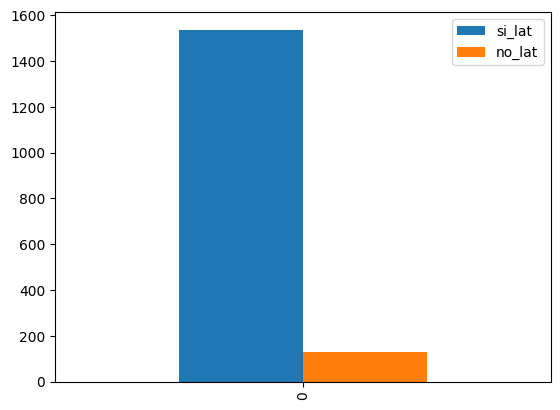

In [401]:
# sección latitud 
empty_lat = 0
no_lat = 0
yes_lat = 0

for x in df['Latitud*'].items():
  xI, xV = x[0], x[1]
  val = validar_latitud(x[1])
  if val:
    yes_lat += 1
  else:
    df.at[xI, 'Latitud*'] = f'[NO LAT] {xV}'
    no_lat += 1

lat = pd.DataFrame(data={"si_lat": [yes_lat], 'no_lat': [no_lat]})
save_df_in_sheet_from_workbook(lat, 'lats_status', wb_df_original_file)
lat.plot(kind='bar')
print(f"No lat: {no_lat}\nSi lat: {yes_lat}")

No lon: 129
Si lon: 1537


<Axes: >

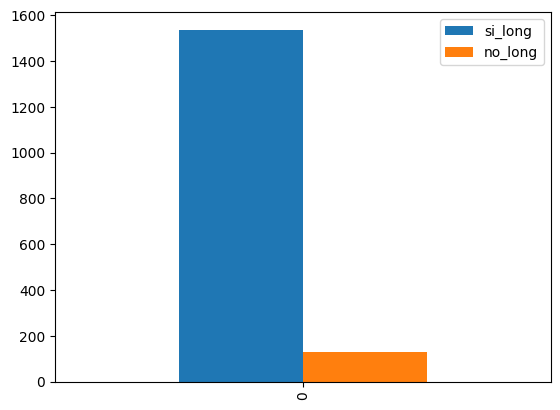

In [402]:
no_lon = 0
yes_lon = 0
for x in df['Longitud*'].items():
  xI, xV = x[0], x[1]
  val = validar_longitud(xV)
  if val:
    yes_lon += 1
  else:
    df.at[xI, 'Longitud*'] = f'[NO LONG] {xV}'
    no_lon += 1

print(f'No lon: {no_lon}\nSi lon: {yes_lon}')

long = pd.DataFrame(data={"si_long": [yes_lon], 'no_long': [no_lon]})
save_df_in_sheet_from_workbook(long, 'longs_status', wb_df_original_file)
long.plot(kind='bar')


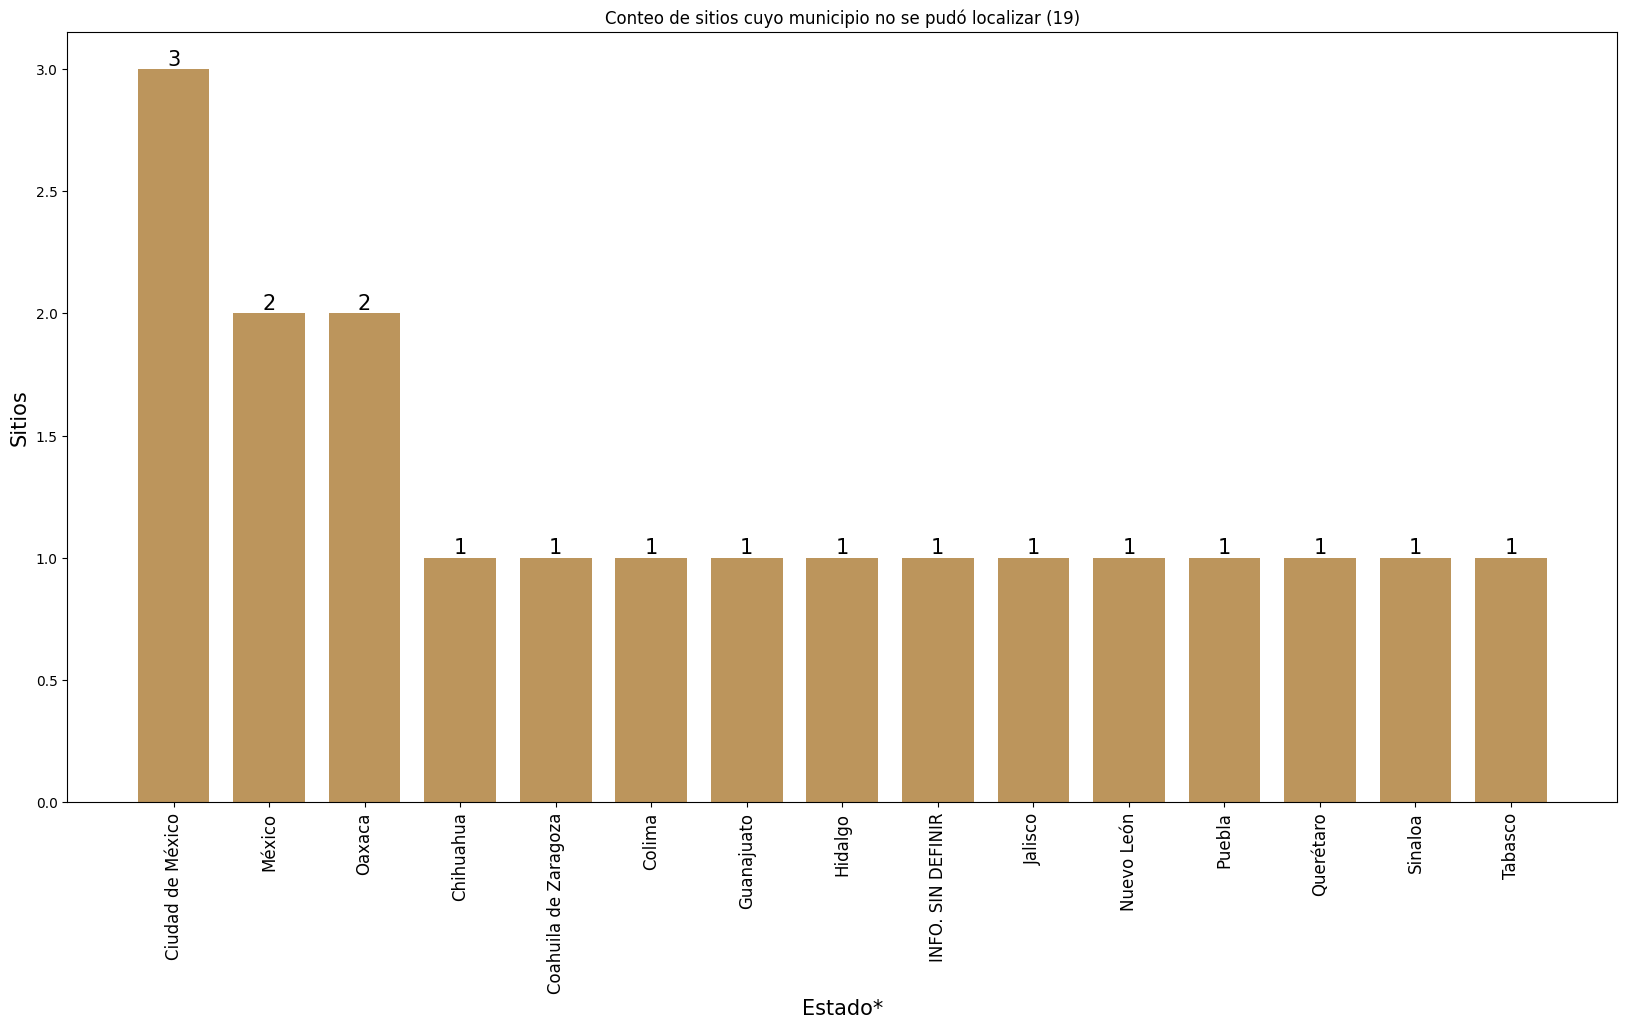

In [403]:
# GRÁFICA  DE MUNICIPIOS NO LOCALIZADOS POR ESTADO 
mun_no_encontrados = df[df['id_mun'] == 0].groupby(by=['Estado*']).agg(conteo=('Estado*', 'count')).reset_index().sort_values(by="conteo", ascending=False) 
total_mun_no_encontrados = mun_no_encontrados['conteo'].sum()

save_df_in_sheet_from_workbook(mun_no_encontrados, 'mun_not_found_by_edo', wb_df_original_file)

# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(20, 10))

# Crear un gráfico de barras
ax.bar( mun_no_encontrados['Estado*'], mun_no_encontrados['conteo'], width=0.75, color='#BC955C')

# Agregar etiquetas a las barras
for x in ax.containers:
    ax.bar_label(x, label_type='edge', fontsize=15)

# Establecer los títulos y etiquetas de los ejes
ax.set_title(f'Conteo de sitios cuyo municipio no se pudó localizar ({total_mun_no_encontrados})')
ax.set_xlabel('Estado*', fontsize=15)
ax.set_ylabel('Sitios', fontsize=15)

# Cambiar las etiquetas del eje x
ax.xaxis.set_major_locator(FixedLocator(range(len(mun_no_encontrados))))
ax.xaxis.set_major_formatter(FixedFormatter(mun_no_encontrados['Estado*']))

# Cambiar las etiquetas del eje x
# abreviaturas_estados = ['BC', 'BCS', 'SON', 'CHI', 'SIN', 'COA', 'NAY', 'DGO', 'ZAC', 'AGS', 'JAL', 'COL', 'MIC', 'GRO', 'QUE', 'SLP', 'GTO', 'HID', 'PUE', 'MEX', 'CDMX', 'TLAX', 'MOR', 'VER', 'TAB', 'CAM', 'YUC', 'ROO', 'QROO']
# ax.set_xticklabels(abreviaturas_estados, fontsize=12)

ax.set_xticklabels(labels=mun_no_encontrados['Estado*'],fontsize=12)

# Girar las etiquetas del eje x
ax.tick_params(axis='x', labelrotation=90)

# Mostrar el gráfico
plt.show()

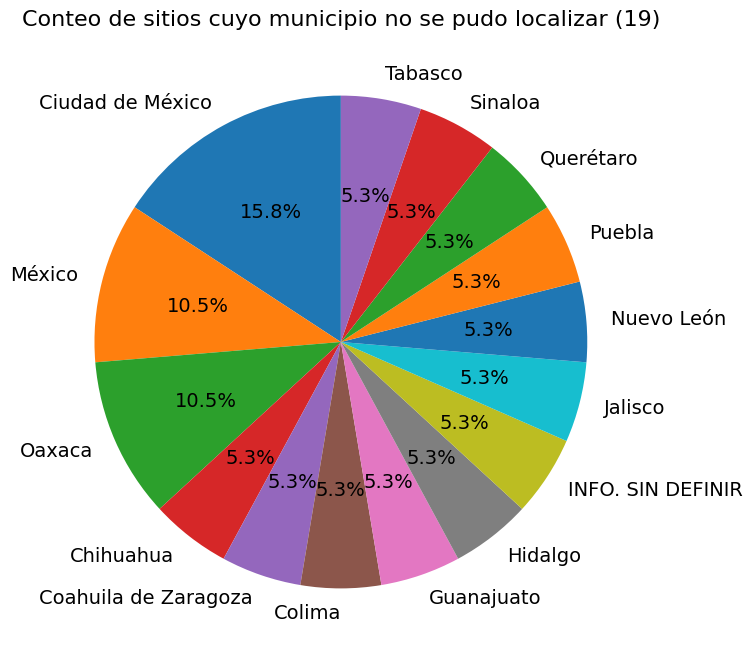

In [404]:


# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(8, 8))

# Crear un gráfico de pay
ax.pie(mun_no_encontrados['conteo'], labels=mun_no_encontrados['Estado*'], autopct='%1.1f%%', startangle=90, textprops={'fontsize': 14})

# Establecer el título del gráfico
ax.set_title(f'Conteo de sitios cuyo municipio no se pudo localizar ({total_mun_no_encontrados})', fontsize=16)

# Mostrar el gráfico
plt.show()


<style>
	h3{
		background-color: orange;
		color: black;
		text-align: center;
		border: 2px solid red;
	}
</style>
<h3>Localidades Prioritarias PROGRAMA DE COBERTURA SOCIAL</h3>

In [405]:
cat_locs_pcs = pd.read_csv('./Compact_inegi_dbLocs/locs_prioritarias_programa_cobertura_social.csv', encoding='utf-8')
# cat_locs_pcs.rename(columns={'ï»¿Clave':'clave_edo_mun_loc'}, inplace=True)


In [406]:
localidades_prioritarias = []
for x in cat_locs_pcs['id_edo'].items():
  xI, xV = x[0], x[1]
  id_edo = cat_locs_pcs['id_edo'].iloc[xI]
  id_mun = cat_locs_pcs['id_mun'].iloc[xI]
  id_loc = cat_locs_pcs['id_loc'].iloc[xI]
  localidades_prioritarias.append('{} | {} | {}'.format(id_edo, id_mun, id_loc)	)


Sitios en localidades prioritarias: 11 | 0.66%
Sitios en localidades NO prioritarias: 1655 | 99.34%
 Total sitios: 1666


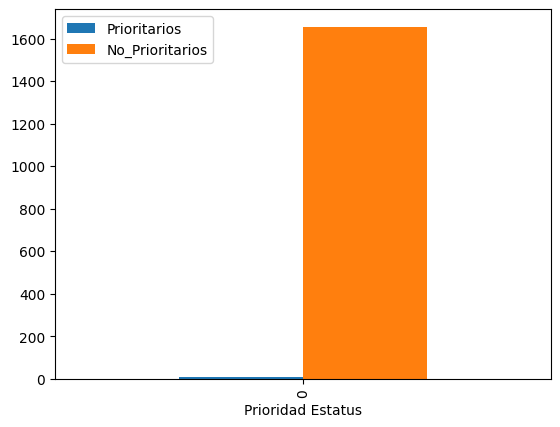

In [407]:
prioritaria = 0
no_prioritaria = 0

status_loc_prioritaria = []
for x in df['id_edo'].items():
  xI, xV = x[0], x[1]
  id_edo = xV
  id_mun = df['id_mun'].iloc[xI]
  id_loc = df['id_loc'].iloc[xI]
  clv = '{} | {} | {}'.format(id_edo, id_mun, id_loc)
  
  if clv in localidades_prioritarias:
    prioritaria += 1
    status_loc_prioritaria.append('Prioritaria') 
  else:
    no_prioritaria += 1
    status_loc_prioritaria.append('No Prioritaria')

total_regs =  prioritaria + no_prioritaria
    
chart_priority = pd.DataFrame([{'Prioritarios': prioritaria, 'No_Prioritarios': no_prioritaria}], columns=['Prioritarios', 'No_Prioritarios'])

save_df_in_sheet_from_workbook(chart_priority, 'locs_tipo_prioridad', wb_df_original_file)

chart_priority.plot(kind='bar', xlabel="Prioridad Estatus" )
p_prioritarias = round((prioritaria / total_regs) * 100, 2)
p_no_prioritarias = round((no_prioritaria / total_regs) * 100, 2)
print(f'Sitios en localidades prioritarias: {prioritaria} | {p_prioritarias}%\nSitios en localidades NO prioritarias: {no_prioritaria} | {p_no_prioritarias}%\n Total sitios: {total_regs}')


In [408]:
try:
  df.insert(27, 'ESTATUS_PRIORIDAD_PCS', status_loc_prioritaria)
except Exception:
  pass

In [409]:
try:
  del tEdosMunLoc
  del cat_locs_pcs
except NameError:
  pass

<style>
	h3{
		background-color: orange;
		color: black;
		text-align: center;
		border: 2px solid red;
	}
</style>
<h3>Población femenina por localidad CENSO 2020</h3>

In [410]:
censo = pd.read_csv('./Compact_inegi_dbLocs/conjunto_de_datos_iter_00CSV20.csv', low_memory=False)
poblacion = censo[['ENTIDAD', 'MUN', 'LOC', 'NOM_LOC', 'POBTOT', 'POBFEM', 'POBMAS']]

In [411]:
poblacion = poblacion[(poblacion.ENTIDAD != 0) & (poblacion.MUN != 0) & (poblacion.LOC != 0)].reset_index()
poblacion = poblacion.replace({'POBTOT':'*','POBFEM':'*', 'POBMAS':'*'},0)
rows_p = poblacion.shape[0]  # 193094 


In [412]:
resultados = []
for i in range(0, rows_p):
  p_mas = int(poblacion['POBMAS'].iloc[i])
  p_fem = int(poblacion['POBFEM'].iloc[i])
  p_total = p_mas + p_fem
  try: 
    p_mas_porcentaje = round((p_mas / p_total) * 100, 2)
    p_fem_porcentaje = round((p_fem / p_total) * 100, 2)
    resultados.append(
      (p_fem_porcentaje, p_mas_porcentaje)
    )
  except ZeroDivisionError:
    resultados.append(
      (0,0)
    )
    
poblacion[['porcentaje_pob_fem', 'porcentaje_pob_mas']] = pd.DataFrame(resultados, columns=['porcentaje_pob_fem', 'porcentaje_pob_mas'])

In [413]:
edo_mun_loc_censo = []
censo_lr  = poblacion.shape[0]
for i in range(0, censo_lr):
  id_edo = poblacion['ENTIDAD'].iloc[i]
  id_mun = poblacion['MUN'].iloc[i]
  id_loc = poblacion['LOC'].iloc[i]
  edo_mun_loc_censo.append(
		'{} | {} | {}'.format(id_edo, id_mun, id_loc)
	)
edo_mun_loc_censo = list(set(edo_mun_loc_censo))

In [414]:
resultados_porcentaje_poblacion = []
df_lr = df.shape[0]
for i in range(0, df_lr):
  id_edo = df['id_edo'].iloc[i]
  id_mun = df['id_mun'].iloc[i]
  id_loc = df['id_loc'].iloc[i]
  clv_edomunloc = '{} | {} | {}'.format(id_edo, id_mun, id_loc)
  if clv_edomunloc in edo_mun_loc_censo:
    main_filtro_pob = poblacion[(poblacion.ENTIDAD == id_edo) & (poblacion.MUN == id_mun) & (poblacion.LOC == id_loc)]
    pob_fem = main_filtro_pob['POBFEM'].iloc[0]
    percentage_pob_fem = main_filtro_pob['porcentaje_pob_fem'].iloc[0]
    pob_mas = main_filtro_pob['POBMAS'].iloc[0]
    percentage_pob_mas = main_filtro_pob['porcentaje_pob_mas'].iloc[0]
    # pob fem | pob mas | pob porcentaje fem | pob porcentaje mas 
    resultados_porcentaje_poblacion.append(
      (pob_fem, pob_mas, percentage_pob_fem, percentage_pob_mas)
    )
  else:
    resultados_porcentaje_poblacion.append(
      (0,0,0,0)
    )


In [415]:
# df.insert(29, ['pob_fem', 'pob_mas', 'porcentaje_pob_fem', 'porcentaje_pob_mas'], resultados_porcentaje_poblacion)
try:
  df.insert(28, 'pob_fem', [x[0] for x in resultados_porcentaje_poblacion])
  df.insert(29, 'pob_mas', [x[1] for x in resultados_porcentaje_poblacion])
  df.insert(30, 'porcentaje_pob_fem', [x[2] for x in resultados_porcentaje_poblacion])
  df.insert(31, 'porcentaje_pob_mas', [x[3] for x in resultados_porcentaje_poblacion])
except ValueError:
  pass

In [416]:

locs_sin_id = df[df['id_loc'] == 0]['Clave de la Dependencia*'].count()
pob_fem_greater_than_half_in_priority_location = df[(df['ESTATUS_PRIORIDAD_PCS'] == 'Prioritaria') & (df['porcentaje_pob_fem'] > 50)]['porcentaje_pob_fem'].count()

df_loc_prio_pob_fem_ge50 = df[(df['ESTATUS_PRIORIDAD_PCS'] == 'Prioritaria') & (df['porcentaje_pob_fem'] > 50)]

save_df_in_sheet_from_workbook(df_loc_prio_pob_fem_ge50, 'locs_prio_and_pob_fem_ge50', wb_df_original_file)

display(HTML(f"<div style='background-color: #6a00f4; padding: 10px; border-bottom: 1px dotted black'>El número de sitios ubicados en localidades donde la población femenina representa al menos el 50% son: <span style='border-bottom: 1px dotted black'>{pob_fem_greater_than_half_in_priority_location}</span></div>"))
print(f"* hay {locs_sin_id} registros los cuales no se les pudo asignar info del CENSO 2020 por falta de id en la localidad ")

* hay 206 registros los cuales no se les pudo asignar info del CENSO 2020 por falta de id en la localidad 


In [417]:
try:
  del censo
  del resultados_porcentaje_poblacion
  del poblacion
except NameError:
  pass

<style>
	h3{
		background-color: red;
		color: black;
		text-align: center;
		border: 2px solid red;
	}
</style>
<h3>DUPLICADOS EN TABLA CONTENEDORA REGISTROS GLOBALES PCSP</h3>

In [418]:
tabla_contenedora_pcsp = pd.read_csv('./Compact_inegi_dbLocs/respaldo_copia_rusp.csv', encoding='utf-8', low_memory=False)

In [419]:
contenedor = tabla_contenedora_pcsp[['Clave del inmueble*', 'Nombre del inmueble*', 'Id_Edo', 'ID_Mun', 'ID_Loc']]
contenedor = contenedor.replace({'Id_Edo':' ', 'ID_Mun':' ', 'ID_Loc':' '}, 0)
contenedor = contenedor.astype({'Id_Edo':'int64', 'ID_Mun':'int64', 'ID_Loc':'int64'})

In [420]:
contenedor['Nombre del inmueble*'] = contenedor['Nombre del inmueble*'].str.lower().str.strip()

In [421]:
lr_contenedor = contenedor.shape[0]

In [422]:
# llaves con base en su nombre del sitios, id edo, id mun y id loc
lst_sin_clv = []
for i in tqdm(range(0, lr_contenedor)):
  clv = contenedor['Clave del inmueble*'].iloc[i]
  nom_sitio = contenedor['Nombre del inmueble*'].iloc[i]
  id_edo = contenedor['Id_Edo'].iloc[i]
  id_mun = contenedor['ID_Mun'].iloc[i]
  id_loc = contenedor['ID_Loc'].iloc[i]
  lst_sin_clv.append(
    '{} | {} | {} | {}'.format(sin_ascentos(nom_sitio), id_edo, id_mun, id_loc)
  )

print(len(lst_sin_clv))

100%|██████████| 224009/224009 [00:08<00:00, 26471.33it/s]

224009


In [423]:
# en este ejemplo se omite el nombre del sitio al suponer que la clave del sitio es el elemento único y principal
lst_con_clv = []
#contenedor[(contenedor['Clave del inmueble*'] == ' ')  & (contenedor['Nombre del inmueble*'] != ' ') ]
sitios_con_clv = contenedor[contenedor['Clave del inmueble*'] != ' '].reset_index()
lr_sitios_con_clv = sitios_con_clv.shape[0]
for i in tqdm(range(0, lr_sitios_con_clv)):
  clv = sitios_con_clv['Clave del inmueble*'].iloc[i]
  id_edo = sitios_con_clv['Id_Edo'].iloc[i]
  id_mun = sitios_con_clv['ID_Mun'].iloc[i]
  id_loc = sitios_con_clv['ID_Loc'].iloc[i]
  lst_con_clv.append('{} | {} | {} | {}'.format(clv, id_edo, id_mun, id_loc))

100%|██████████| 218949/218949 [00:06<00:00, 34176.11it/s]


<style>
	h3{
		background-color: orange;
		color: black;
		text-align: center;
		border: 2px solid red;
	}
</style>
<h3>Analisis final df vs tabla contenedora</h3>

In [424]:
# listas : lst_sin_clv y lst_con_clv
# generar la lista de id de cada registro que se encuentre en las dos listas de llaves 
lst_repetidos = []
lr_df = df.shape[0]
for i in tqdm(range(0, lr_df)):
  clv = df['Clave del inmueble*'].iloc[i]
  nom_inmueble = str(df['Nombre del inmueble*'].iloc[i]).lower().strip()
  id_edo = df['id_edo'].iloc[i]
  id_mun = df['id_mun'].iloc[i]
  id_loc = df['id_loc'].iloc[i]
  temp1 = f'{clv} | {id_edo} | {id_mun} | {id_loc}'
  temp2 = f'{sin_ascentos(nom_inmueble)} | {id_edo} | {id_mun} | {id_loc}'
  if temp1 in lst_con_clv or temp2 in lst_sin_clv:
    lst_repetidos.append(i)

100%|██████████| 1666/1666 [00:07<00:00, 214.38it/s]


In [425]:
# agregar la columna de index a el df para poder vincular con la lista de index repetidos
col_index = df.index.values.tolist()
df['col_index'] = col_index

In [426]:
# creación de dos df con registros unicos no repetidos en la tabla contenedora y otro df con registros que estan en la tabla contenedora
df_registros_unicos_no_en_contenedor = df[df['col_index'].isin(lst_repetidos) == False]
registros_en_contenedor = df[df['col_index'].isin(lst_repetidos) == True]

save_df_in_sheet_from_workbook(registros_en_contenedor, 'regs_in_main_db', wb_df_original_file)

In [427]:
# eliminación de las columnas con el label col_index
try:
  df_registros_unicos_no_en_contenedor.drop(labels=['col_index'], axis=1, inplace=True)
  registros_en_contenedor.drop(labels=['col_index'], axis=1, inplace=True)
except KeyError:
  pass

C:\Users\davic\AppData\Local\Temp\ipykernel_13324\2900231960.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_registros_unicos_no_en_contenedor.drop(labels=['col_index'], axis=1, inplace=True)
C:\Users\davic\AppData\Local\Temp\ipykernel_13324\2900231960.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  registros_en_contenedor.drop(labels=['col_index'], axis=1, inplace=True)


In [428]:
# contar registros por clave de inmueble
df_conteo_clv = df_registros_unicos_no_en_contenedor.groupby(by='Clave del inmueble*').agg(conteo_por_clv=('Clave del inmueble*', 'count')).sort_values(by='conteo_por_clv', ascending=False).reset_index()
#obtener solo los registros cuyo conteo es mayor a 1
df_clv_dupli_conteo = df_conteo_clv[(df_conteo_clv['conteo_por_clv']>=2) & (df_conteo_clv['Clave del inmueble*'] != ' ')]
# lista de clave duplicadas para crear matriz de una dimensión
lst_duplicados_clv = list(df_clv_dupli_conteo['Clave del inmueble*'].to_list())

In [429]:
# guardar solo los registros que estan duplicados en el documento interno (analizado)
df_regs_duplicados_final =  df_registros_unicos_no_en_contenedor[df_registros_unicos_no_en_contenedor['Clave del inmueble*'].isin(lst_duplicados_clv) == True].sort_values(by='Clave del inmueble*', ascending=False)
# save_df_changes(df_regs_duplicados_final, "registros_duplicados_en_doc_intern_remitido_por_dependencia")
save_df_in_sheet_from_workbook(df_regs_duplicados_final, 'regs_duplicados_en_df_original', wb_df_original_file)

In [430]:
regs_unicos = df_registros_unicos_no_en_contenedor.shape[0]
regs_en_contenedor_glob = registros_en_contenedor.shape[0]
display(HTML(f'<h3 style="color: green;">Registros unicos NO incluidos en la tabla contenedora: {regs_unicos}</h3><h3 Style="color: red;">Registros que ya estan en la tabla contenedora global: {regs_en_contenedor_glob}</h3>'))

In [431]:
texto = '''Descripción de archivos:
* registros_dupli_en_gran_tabla_contenedora.xlsx: son todos los registros duplicados encontrados en el documento analizado y comparado con la tabla contenedora de todos los registros de sitios, se compara clave del sitio, nombre del sitio, id edo, id mun y id loc.

* registros_duplicados_en_doc_intern_remitido_por_dependencia.xlsx: dentro del documento remitido y analizado, son todos los registros duplicados a partir de la clave del inmueble

* regs_no_en_tbl_contenedora_con_reps_intrn.xlsx: son todos los registros no duplicados en la tabla contenedora, sin embargo, si trae todos los registros duplicados por clave dentro del mismo archivo remitido por la dependencia.
'''

with open('./Cambios_aplicados/readme.txt', mode='w') as file:
  file.write(texto)
  file.close()

In [432]:
try:
  del tabla_contenedora_pcsp
  del lst_repetidos
  del lst_sin_clv
  del lst_con_clv
except NameError:
  pass

In [433]:
# conteo de registros por dependencias
f_conteo_x_dep = df_registros_unicos_no_en_contenedor.groupby(by='Dependencia*').agg(conteo_por_dep=('Dependencia*', 'count')).sort_values(by='conteo_por_dep',ascending=False).reset_index()

total_regs = f_conteo_x_dep['conteo_por_dep'].sum()


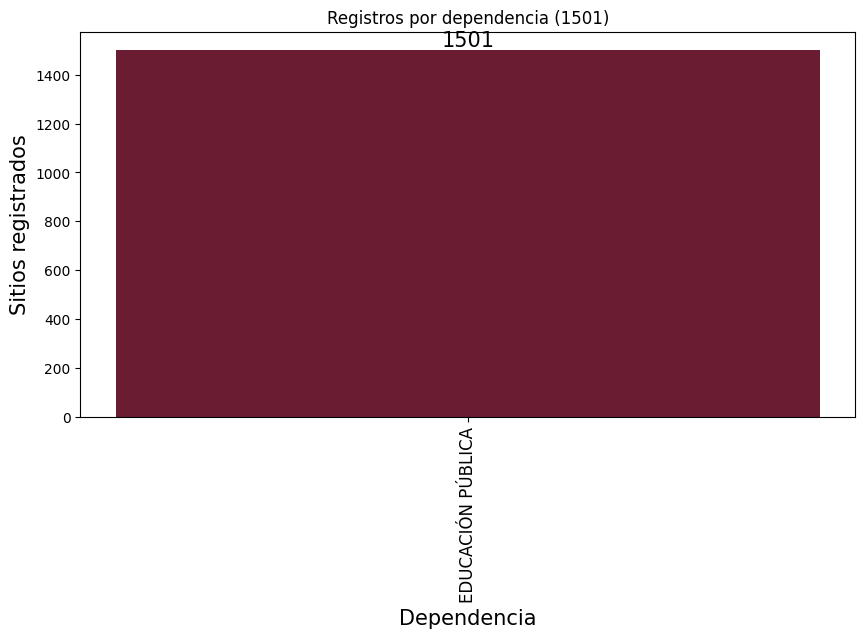

In [434]:
# crear instancia de gráfico
fig, ax = plt.subplots(figsize=(10, 5))

# Crear un gráfico de barras
ax.bar( f_conteo_x_dep['Dependencia*'], f_conteo_x_dep['conteo_por_dep'], width=0.75, color='#691C32')

# Agregar etiquetas a las barras
for x in ax.containers:
    ax.bar_label(x, label_type='edge', fontsize=15)

# Establecer los títulos y etiquetas de los ejes
ax.set_title(f'Registros por dependencia ({total_regs})')
ax.set_xlabel('Dependencia', fontsize=15)
ax.set_ylabel('Sitios registrados', fontsize=15)

# Cambiar las etiquetas del eje x
ax.xaxis.set_major_locator(FixedLocator(range(len(f_conteo_x_dep))))
ax.xaxis.set_major_formatter(FixedFormatter(f_conteo_x_dep['Dependencia*']))

# Cambiar las etiquetas del eje x
# abreviaturas_estados = ['BC', 'BCS', 'SON', 'CHI', 'SIN', 'COA', 'NAY', 'DGO', 'ZAC', 'AGS', 'JAL', 'COL', 'MIC', 'GRO', 'QUE', 'SLP', 'GTO', 'HID', 'PUE', 'MEX', 'CDMX', 'TLAX', 'MOR', 'VER', 'TAB', 'CAM', 'YUC', 'ROO', 'QROO']
# ax.set_xticklabels(abreviaturas_estados, fontsize=12)

ax.set_xticklabels(labels=f_conteo_x_dep['Dependencia*'],fontsize=12)

# Girar las etiquetas del eje x
ax.tick_params(axis='x', labelrotation=90)

# Mostrar el gráfico
plt.show()

In [435]:
# conteo de registros por estado
conteo_sitios_por_edo = df_registros_unicos_no_en_contenedor.groupby(by='Estado*').agg(conteo_sitios_por_edo=('Estado*', 'count')).reset_index().sort_values(by='conteo_sitios_por_edo', ascending=False)

total_sitios_por_edo = conteo_sitios_por_edo['conteo_sitios_por_edo'].sum()

save_df_in_sheet_from_workbook(conteo_sitios_por_edo, 'count_regs_by_edo', wb_df_final_file)

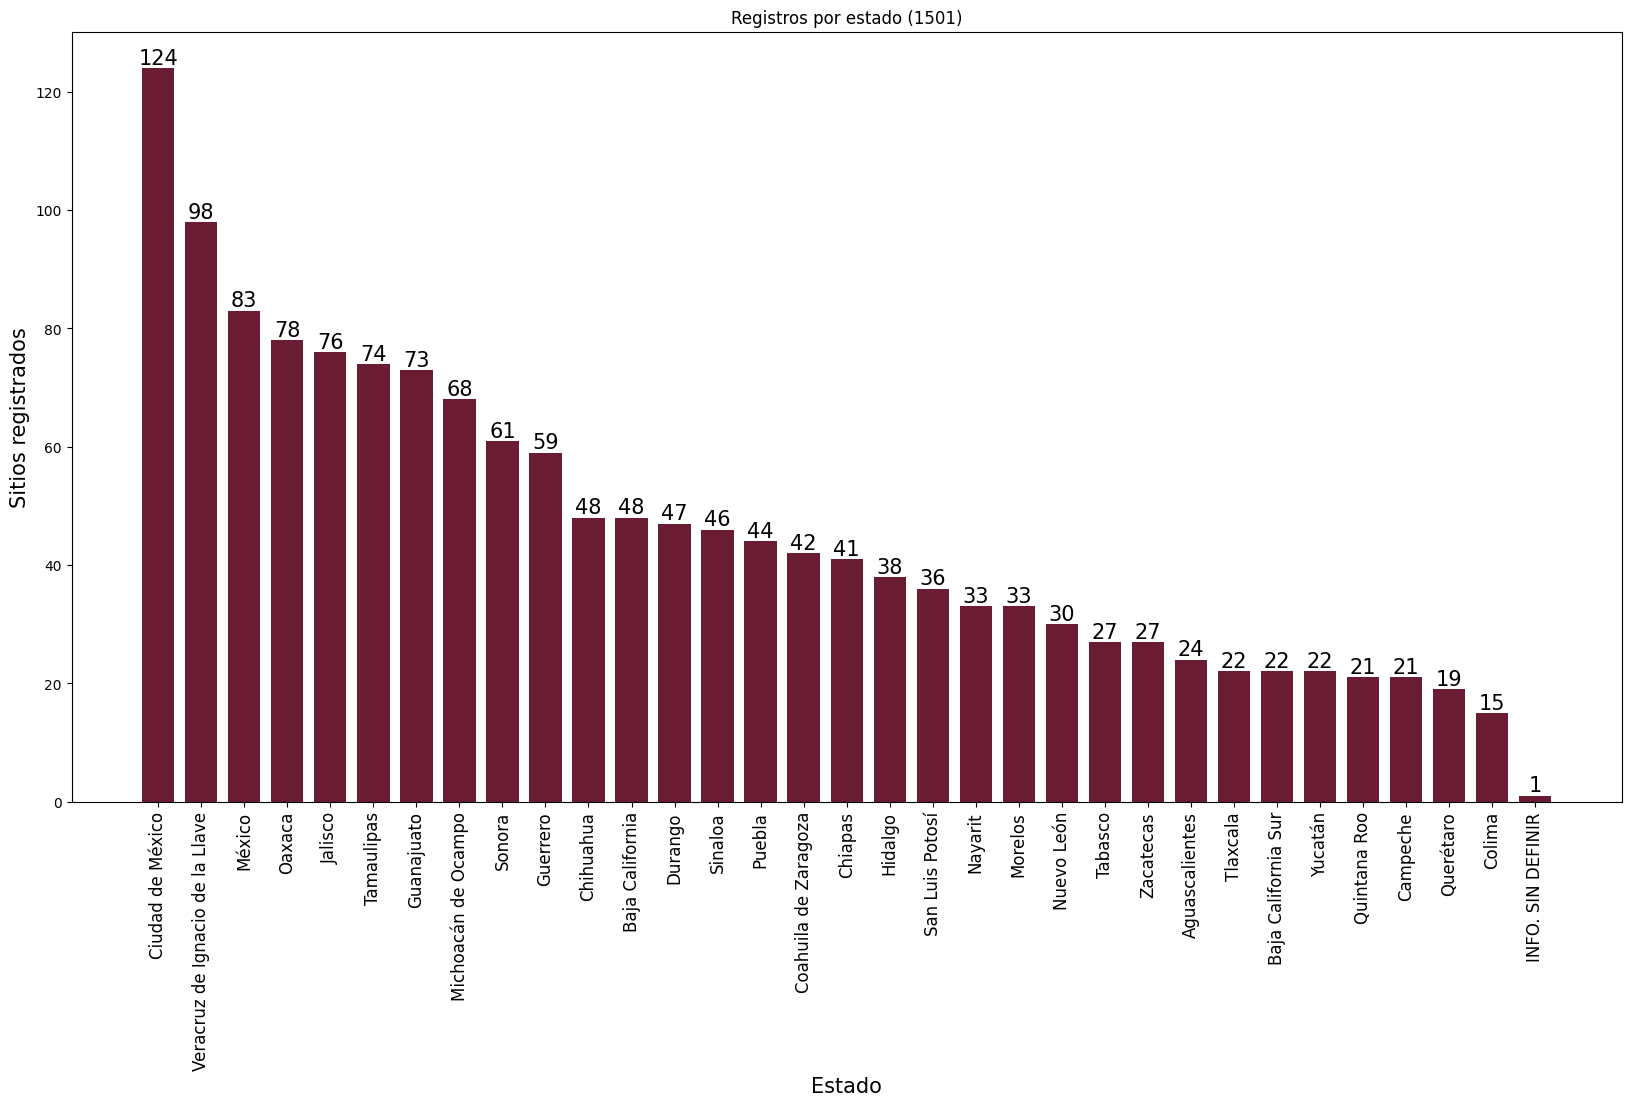

In [436]:
# crear instancia de gráfico
fig, ax = plt.subplots(figsize=(20, 10))

# Crear un gráfico de barras
ax.bar( conteo_sitios_por_edo['Estado*'], conteo_sitios_por_edo['conteo_sitios_por_edo'], width=0.75, color='#691C32')

# Agregar etiquetas a las barras
for x in ax.containers:
    ax.bar_label(x, label_type='edge', fontsize=15)

# Establecer los títulos y etiquetas de los ejes
ax.set_title(f'Registros por estado ({total_sitios_por_edo})')
ax.set_xlabel('Estado', fontsize=15)
ax.set_ylabel('Sitios registrados', fontsize=15)

# Cambiar las etiquetas del eje x
ax.xaxis.set_major_locator(FixedLocator(range(len(conteo_sitios_por_edo))))
ax.xaxis.set_major_formatter(FixedFormatter(conteo_sitios_por_edo['Estado*']))

# Cambiar las etiquetas del eje x
# abreviaturas_estados = ['BC', 'BCS', 'SON', 'CHI', 'SIN', 'COA', 'NAY', 'DGO', 'ZAC', 'AGS', 'JAL', 'COL', 'MIC', 'GRO', 'QUE', 'SLP', 'GTO', 'HID', 'PUE', 'MEX', 'CDMX', 'TLAX', 'MOR', 'VER', 'TAB', 'CAM', 'YUC', 'ROO', 'QROO']
# ax.set_xticklabels(abreviaturas_estados, fontsize=12)

ax.set_xticklabels(labels=conteo_sitios_por_edo['Estado*'],fontsize=12)

# Girar las etiquetas del eje x
ax.tick_params(axis='x', labelrotation=90)

# Mostrar el gráfico
plt.show()

In [437]:
# conteo de registros los cuales no se pudieron localidar en la db del inegi
conteo_regs_no_id_loc =  df_registros_unicos_no_en_contenedor[(df_registros_unicos_no_en_contenedor['id_loc'] == 0)].groupby(by='Estado*')
conteo_regs_no_id_loc = conteo_regs_no_id_loc.agg(conteo_edo_mun_loc=('Estado*', 'count')).reset_index().sort_values(by='conteo_edo_mun_loc', ascending=False)
total_locs_no_localizadas = conteo_regs_no_id_loc['conteo_edo_mun_loc'].sum()
save_df_in_sheet_from_workbook(conteo_regs_no_id_loc, 'count_locs_not_found_by_edo', wb_df_final_file)

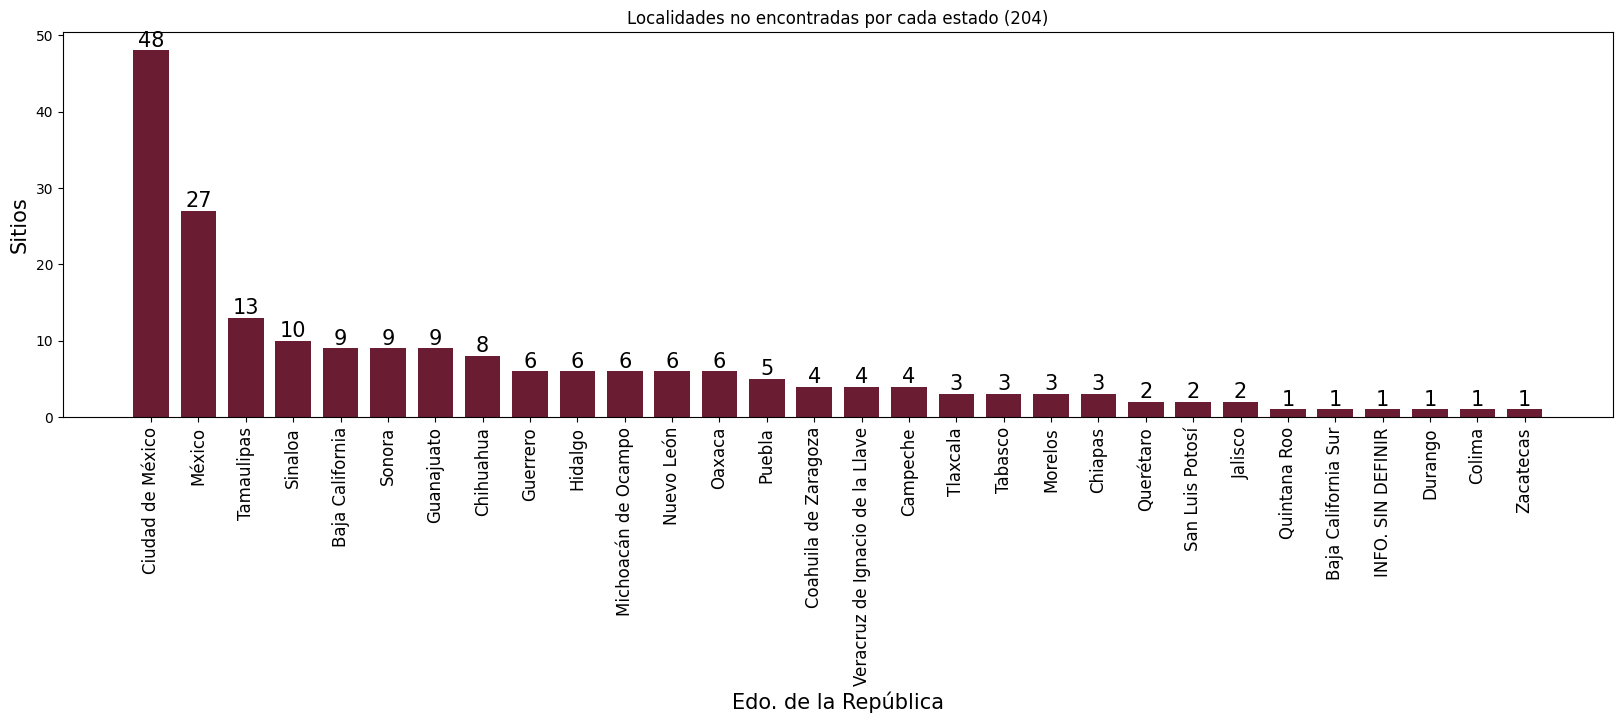

In [438]:
# crear instancia de gráfico
fig, ax = plt.subplots(figsize=(20, 5))

# Crear un gráfico de barras
ax.bar( conteo_regs_no_id_loc['Estado*'], conteo_regs_no_id_loc['conteo_edo_mun_loc'], width=0.75, color='#691C32')

# Agregar etiquetas a las barras
for x in ax.containers:
    ax.bar_label(x, label_type='edge', fontsize=15)

# Establecer los títulos y etiquetas de los ejes
ax.set_title(f'Localidades no encontradas por cada estado ({total_locs_no_localizadas})')
ax.set_xlabel('Edo. de la República', fontsize=15)
ax.set_ylabel('Sitios', fontsize=15)

# Cambiar las etiquetas del eje x
ax.xaxis.set_major_locator(FixedLocator(range(len(conteo_regs_no_id_loc))))
ax.xaxis.set_major_formatter(FixedFormatter(conteo_regs_no_id_loc['Estado*']))

# Cambiar las etiquetas del eje x
# abreviaturas_estados = ['BC', 'BCS', 'SON', 'CHI', 'SIN', 'COA', 'NAY', 'DGO', 'ZAC', 'AGS', 'JAL', 'COL', 'MIC', 'GRO', 'QUE', 'SLP', 'GTO', 'HID', 'PUE', 'MEX', 'CDMX', 'TLAX', 'MOR', 'VER', 'TAB', 'CAM', 'YUC', 'ROO', 'QROO']
# ax.set_xticklabels(abreviaturas_estados, fontsize=12)

ax.set_xticklabels(labels=conteo_regs_no_id_loc['Estado*'],fontsize=12)

# Girar las etiquetas del eje x
ax.tick_params(axis='x', labelrotation=90)

# Mostrar el gráfico
plt.show()

In [439]:
lr_df_final = df_registros_unicos_no_en_contenedor.shape[0]
si_lat = 0
no_lat = 0
si_lon = 0
no_lon = 0
for i in tqdm(range(0, lr_df_final)):
  lat = df_registros_unicos_no_en_contenedor['Latitud*'].iloc[i]
  lon = df_registros_unicos_no_en_contenedor['Longitud*'].iloc[i]
  
  if "[NO LAT]" not in f'{lat}':
    si_lat += 1 
  else:
    no_lat += 1
  
  if '[NO LONG]' not in f'{lon}':
    si_lon += 1
  else:
    no_lon += 1


100%|██████████| 1501/1501 [00:00<00:00, 63787.66it/s]


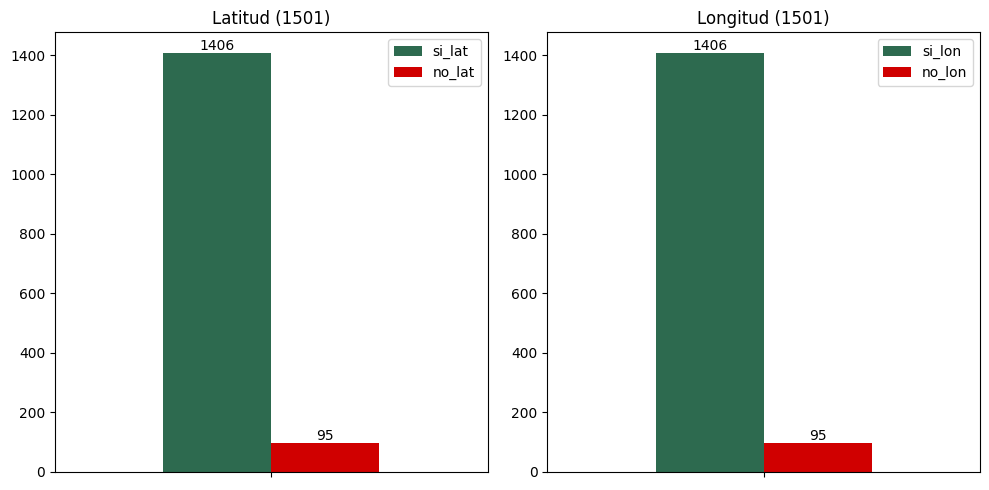

In [440]:

# Crear los dataframes
data_lat = {"si_lat": [si_lat], 'no_lat':[no_lat]}
data_lon = {'si_lon': [si_lon], 'no_lon': [no_lon]}
estatus_lat = pd.DataFrame(data_lat)
estatus_lon = pd.DataFrame(data_lon)

# Crear la figura y los subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Graficar cada dataframe en un subplot
estatus_lat.plot(kind='bar', ax=ax[0], color={"si_lat": '#2d6a4f', "no_lat": "#d00000"})
estatus_lon.plot(kind='bar', ax=ax[1], color={'si_lon': '#2d6a4f', 'no_lon':'#d00000'})

# Eliminar las etiquetas del eje x en ambos subplots
ax[0].set_xticklabels([])
ax[1].set_xticklabels([])

# Añadir los valores a las columnas subplot 0
for x in ax[0].containers:
  ax[0].bar_label(x)

# Añadir los valores a las columnas subplot 1
for r in ax[1].containers:
  ax[1].bar_label(r)

# Personalizar los subplots
ax[0].set_title(f'Latitud ({si_lat + no_lat})')
ax[1].set_title(f'Longitud ({si_lon + no_lon})')
plt.tight_layout()

# Mostrar el gráfico
plt.show()


In [441]:
save_df_in_sheet_from_workbook(estatus_lat, 'regs_no_lat', wb_df_final_file)
save_df_in_sheet_from_workbook(estatus_lon, 'regs_no_long', wb_df_final_file)  

In [442]:
# localidades con población mayormente (<50%) femenina [NO INCLUYE LOCALIDADES PRIORITARIAS]
# -> conteo de todos los sitios por estado
sitios_por_edo = df_registros_unicos_no_en_contenedor.groupby(by='Estado*').agg(sitios_edo=('Estado*', 'count')).reset_index()

# -> conteo de localidades por cada uno de los estados donde la población femenina representa al menos el 50%
sitios_pob_fem_gt_50 = df_registros_unicos_no_en_contenedor[(df_registros_unicos_no_en_contenedor['porcentaje_pob_fem'] >= 50)].groupby(by='Estado*').agg(conteo_locs_pob_fem_gt_50=('Estado*', 'count')).reset_index()

# -> conteo de sitios donde la población femenina representa al menos el 50% y además esta clasificada como una localidad prioritaria PCSP
sitios_pob_fem_gt50_n_prioritaria = df_registros_unicos_no_en_contenedor[(df_registros_unicos_no_en_contenedor['porcentaje_pob_fem'] >= 50) & (df_registros_unicos_no_en_contenedor['ESTATUS_PRIORIDAD_PCS'] == 'Prioritaria')].groupby(by='Estado*').agg(sitios_pob_fem_gt50_n_prioritaria=('Estado*', 'count')).reset_index()


In [443]:
save_df_in_sheet_from_workbook(sitios_pob_fem_gt_50, 'count_sitios_pop_fem_ge50', wb_df_final_file)
save_df_in_sheet_from_workbook(sitios_pob_fem_gt50_n_prioritaria, 'count_s_pop_fem_ge50_n_prior', wb_df_final_file)

In [446]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.bar.html
tipo_pob_por_loc = pd.merge(sitios_por_edo, sitios_pob_fem_gt_50, on='Estado*')
col_no_fem_gt50_otros = []
lr_pob_loc_gt50 =  tipo_pob_por_loc.shape[0]
for i in tqdm(range(0, lr_pob_loc_gt50)):
  sitios_edos = tipo_pob_por_loc['sitios_edo'].iloc[i]
  sitios_pob_bt50 = tipo_pob_por_loc['conteo_locs_pob_fem_gt_50'].iloc[i]
  dif = sitios_edos - sitios_pob_bt50
  col_no_fem_gt50_otros.append(dif)

save_df_in_sheet_from_workbook(tipo_pob_por_loc, 'sitios_by_edo_and_pog_fem_ge50', wb_df_final_file)

100%|██████████| 32/32 [00:00<00:00, 31790.08it/s]


In [447]:
try:
  tipo_pob_por_loc.insert(3, 'no_pob_fem_gt50_otros', col_no_fem_gt50_otros)
except ValueError:
  pass

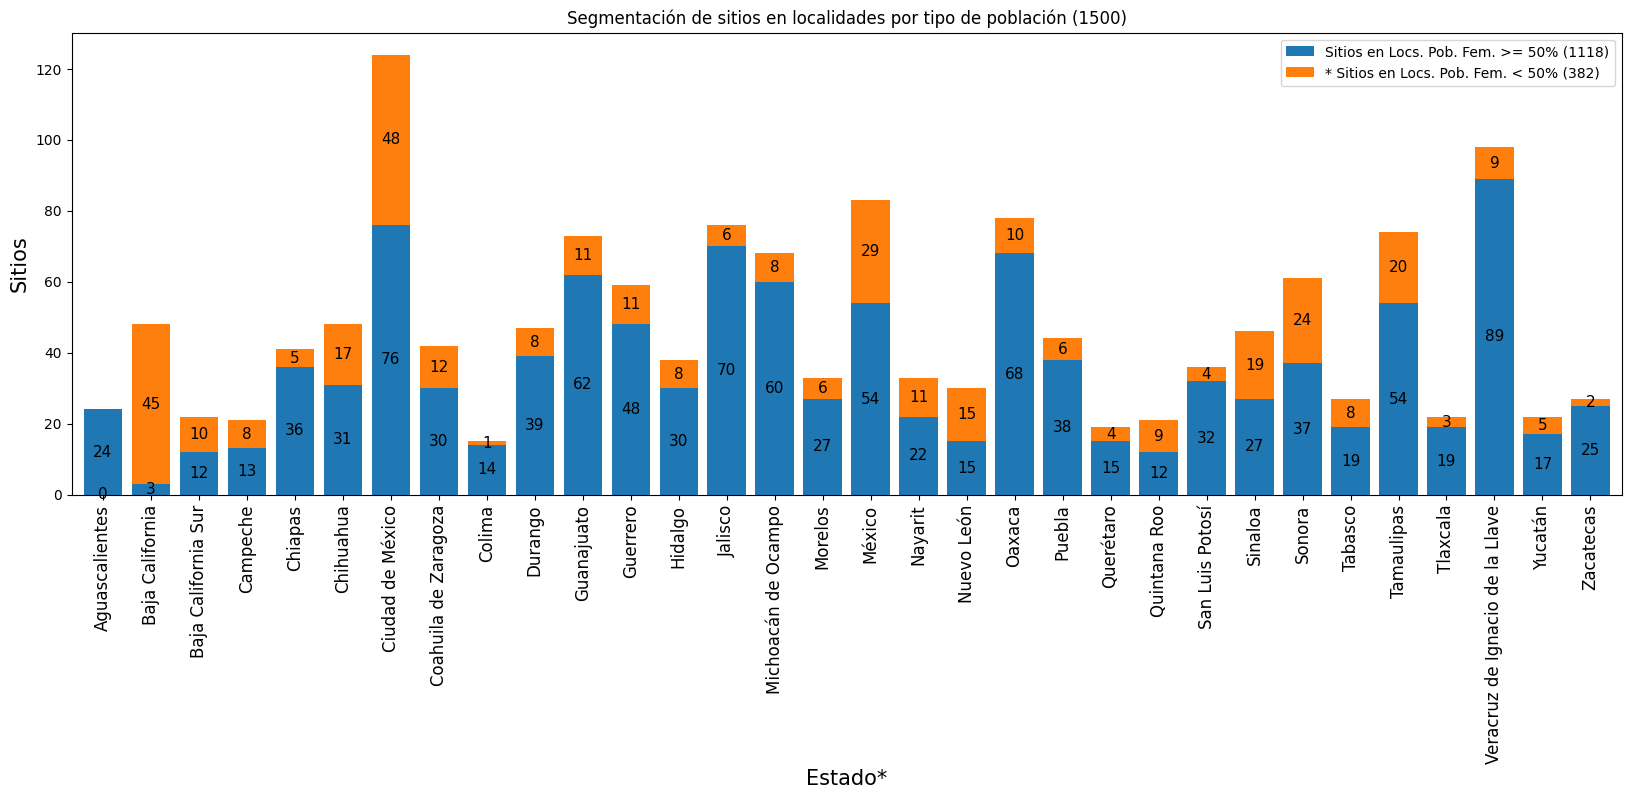

In [450]:
# crear leyenda
display(HTML('<h2 style="background-color: red; color: white; text-align: center;">* Solo se mostraran en la gráfica los registros que si tienen id estado, id municipio y id localidad </h2>'))

# crear tabla compactada de variables a graficar
concentrado_pob_fem_por_loc_NO_PRIORITARIOS = tipo_pob_por_loc[['Estado*','conteo_locs_pob_fem_gt_50', 'no_pob_fem_gt50_otros']]
# variables de conteos:
sitios_loc_pob_ge50 = concentrado_pob_fem_por_loc_NO_PRIORITARIOS['conteo_locs_pob_fem_gt_50'].sum()
sitios_loc_pob_lt50 =  concentrado_pob_fem_por_loc_NO_PRIORITARIOS['no_pob_fem_gt50_otros'].sum()

# crear instancia de gráfico
grafica_pob_fem = concentrado_pob_fem_por_loc_NO_PRIORITARIOS.plot(kind='bar', stacked=True, figsize=(20,6), width=0.8)

# Establecer los títulos y etiquetas de los ejes
grafica_pob_fem.set_title(f'Segmentación de sitios en localidades por tipo de población ({sitios_loc_pob_ge50 + sitios_loc_pob_lt50})')
grafica_pob_fem.set_xlabel('Estado*', fontsize=15)
grafica_pob_fem.set_ylabel('Sitios', fontsize=15)

# Cambiar las etiquetas del eje x
grafica_pob_fem.xaxis.set_major_locator(FixedLocator(range(len(concentrado_pob_fem_por_loc_NO_PRIORITARIOS['Estado*']))))
grafica_pob_fem.xaxis.set_major_formatter(FixedFormatter(concentrado_pob_fem_por_loc_NO_PRIORITARIOS['Estado*']))

# cambiar el tamaño de la fuente del las etiquetas de las barras del eje x
grafica_pob_fem.set_xticklabels(labels=concentrado_pob_fem_por_loc_NO_PRIORITARIOS['Estado*'], fontsize=12)

# # Girar las etiquetas del eje x
grafica_pob_fem.tick_params(axis='x', labelrotation=90)

# asignar valores a las columnas 
for x in grafica_pob_fem.containers:
  # grafica_pob_fem.bar_label(x, label_type='edge', fontsize=11)
  grafica_pob_fem.bar_label(x, label_type='center', fontsize=11)

# Personalizar los nombres de los grupos gráficos
grupo_nombres = [f'Sitios en Locs. Pob. Fem. >= 50% ({sitios_loc_pob_ge50})', f'* Sitios en Locs. Pob. Fem. < 50% ({sitios_loc_pob_lt50})']
grafica_pob_fem.legend(grupo_nombres, loc='upper right')

plt.show()

save_df_in_sheet_from_workbook(concentrado_pob_fem_por_loc_NO_PRIORITARIOS, 'count_sites_by_tipe_pop_loc', wb_df_final_file)

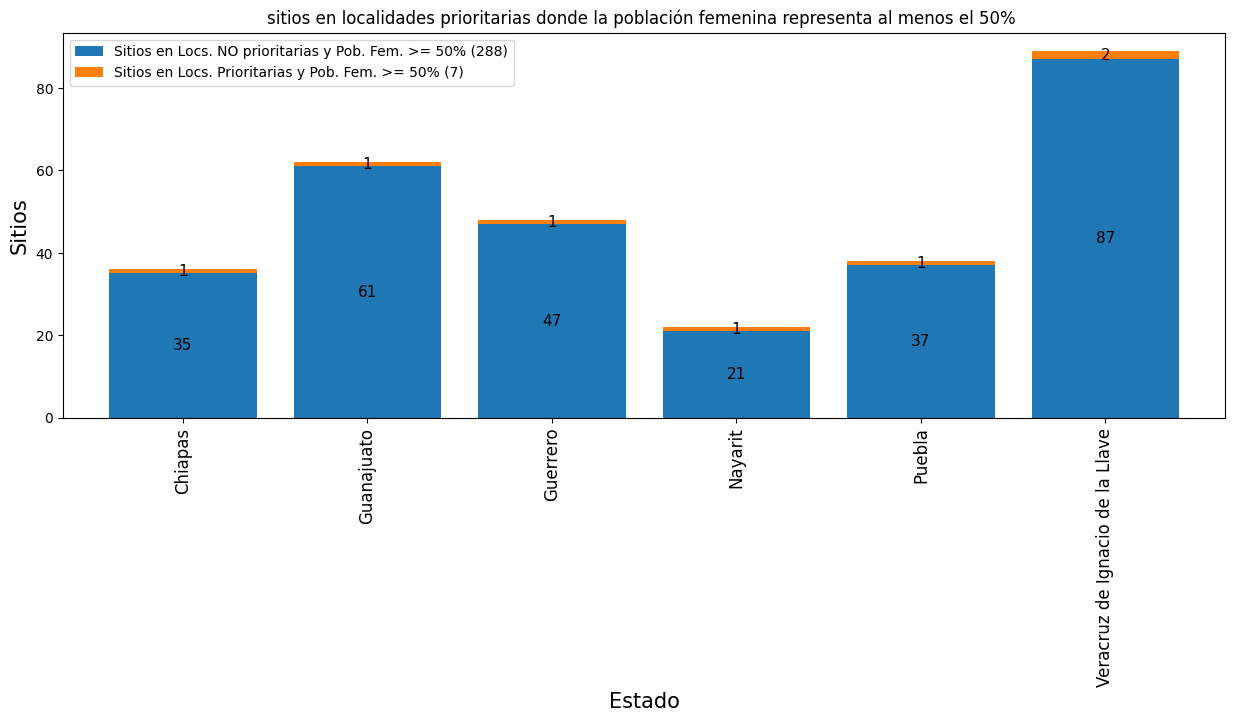

In [451]:

# sitios_pob_fem_gt50_n_prioritaria = sitios en poblacion donde las mujeres son al menos el +50% Y(n) la localidad es prioritaria

locs_fem_prio_gt50 = pd.merge(left=tipo_pob_por_loc, right=sitios_pob_fem_gt50_n_prioritaria, on='Estado*')
locs_fem_prio_gt50['pob_fem_sin_prio'] = locs_fem_prio_gt50['conteo_locs_pob_fem_gt_50'] - locs_fem_prio_gt50['sitios_pob_fem_gt50_n_prioritaria']
sitios_en_loc_pob_fem = locs_fem_prio_gt50[['Estado*','pob_fem_sin_prio', 'sitios_pob_fem_gt50_n_prioritaria']]

# -----------------------------------------------------------------------------------------------------------------

sitios_pob_fem_y_prioritarias = sitios_en_loc_pob_fem['sitios_pob_fem_gt50_n_prioritaria'].sum()
sitios_pob_fem_no_prioritarias = sitios_en_loc_pob_fem['pob_fem_sin_prio'].sum()

#crear instancia de gráfico
graf_pob_fem_locs_prio = sitios_en_loc_pob_fem.plot(kind='bar', stacked=True, figsize=(15,5), width=0.8)

# Establecer los títulos y etiquetas de los ejes
graf_pob_fem_locs_prio.set_title(f'sitios en localidades prioritarias donde la población femenina representa al menos el 50% ')
graf_pob_fem_locs_prio.set_xlabel('Estado', fontsize=15)
graf_pob_fem_locs_prio.set_ylabel('Sitios', fontsize=15)

# Cambiar las etiquetas del eje x
graf_pob_fem_locs_prio.xaxis.set_major_locator(FixedLocator(range(len(sitios_en_loc_pob_fem['Estado*']))))
graf_pob_fem_locs_prio.xaxis.set_major_formatter(FixedFormatter(sitios_en_loc_pob_fem['Estado*']))

# cambiar el tamaño de la fuente del las etiquetas de las barras del eje x
graf_pob_fem_locs_prio.set_xticklabels(labels=sitios_en_loc_pob_fem['Estado*'], fontsize=12)

# # Girar las etiquetas del eje x
graf_pob_fem_locs_prio.tick_params(axis='x', labelrotation=90)

# asignar valores a las columnas 
for x in graf_pob_fem_locs_prio.containers:
  # grafica_pob_fem.bar_label(x, label_type='edge', fontsize=11)
  graf_pob_fem_locs_prio.bar_label(x, label_type='center', fontsize=11)

# Personalizar los nombres de los grupos gráficos
grupo_nombres = [f'Sitios en Locs. NO prioritarias y Pob. Fem. >= 50% ({sitios_pob_fem_no_prioritarias})', f'Sitios en Locs. Prioritarias y Pob. Fem. >= 50% ({sitios_pob_fem_y_prioritarias}) ']
graf_pob_fem_locs_prio.legend(grupo_nombres, loc='best') #loc='upper right'

plt.show()



In [452]:
# crear gráfico de localidades prioritarias y no prioritarias por estado [SIN TIPO GÉNERO POBLACIÓN]
main_tbl_sitios_por_tipo_rpioridad =  df_registros_unicos_no_en_contenedor.groupby(by='Estado*').agg(conteo_sitios_x_edo=('Estado*', 'count')).reset_index()
no_prioritarios_x_edo = df_registros_unicos_no_en_contenedor[df_registros_unicos_no_en_contenedor['ESTATUS_PRIORIDAD_PCS'] == 'No Prioritaria'].groupby(by='Estado*').agg(conteo_no_prioritarios=('Estado*', 'count')).reset_index()
prioritarios_x_edo = df_registros_unicos_no_en_contenedor[(df_registros_unicos_no_en_contenedor['ESTATUS_PRIORIDAD_PCS'] == 'Prioritaria')].groupby(by='Estado*').agg(conteo_prioritarios=('Estado*', 'count')).reset_index()

In [460]:
conteo_por_prioridad_y_edo = pd.merge(left=main_tbl_sitios_por_tipo_rpioridad, right=no_prioritarios_x_edo, on='Estado*')
conteo_por_prioridad_y_edo = pd.merge(left=conteo_por_prioridad_y_edo, right=prioritarios_x_edo, on='Estado*')
conteo_por_prioridad_y_edo = conteo_por_prioridad_y_edo[['Estado*', 'conteo_no_prioritarios', 'conteo_prioritarios']]
sitios_en_locs_prio = conteo_por_prioridad_y_edo['conteo_prioritarios'].sum()
save_df_in_sheet_from_workbook(conteo_por_prioridad_y_edo[['Estado*','conteo_prioritarios']], 'count_regs_locs_prio_by_edo', wb_df_final_file)

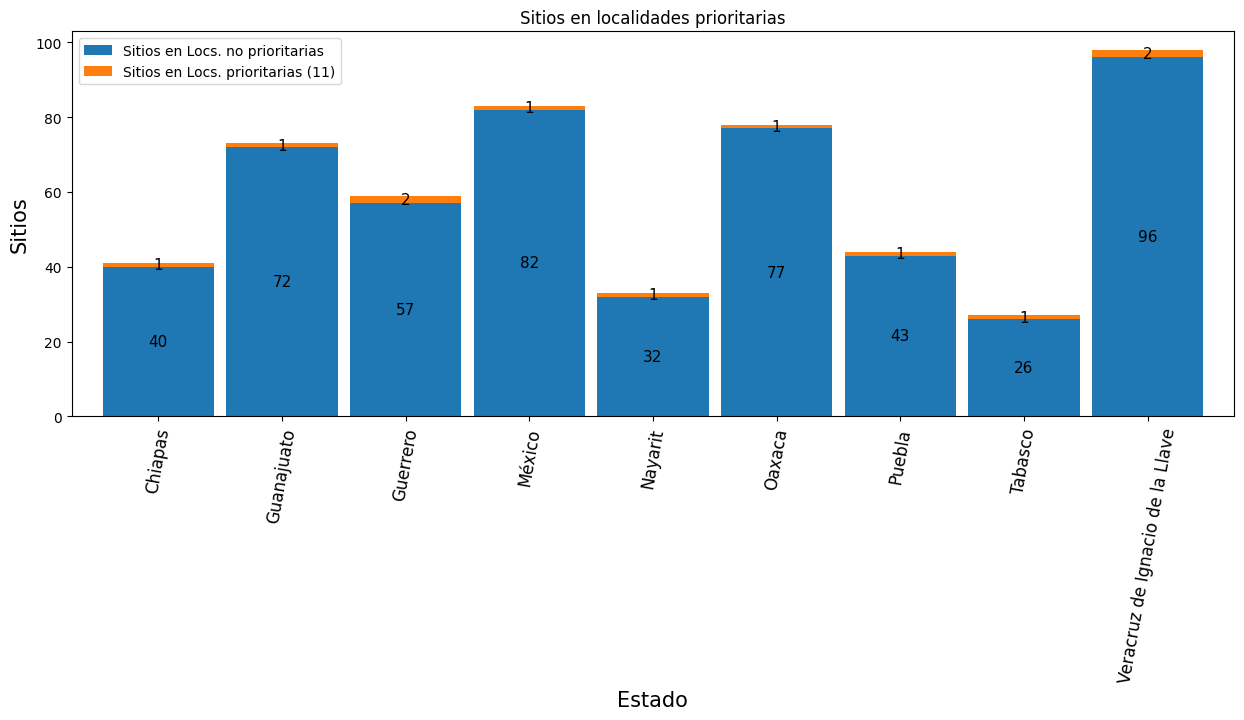

In [461]:
# crear instancia de gráfico
grafica_locs_prioritarias = conteo_por_prioridad_y_edo.plot(kind='bar', stacked=True, figsize=(15, 5), width=0.9)

# establecer títulos y gráficos
grafica_locs_prioritarias.set_title(f'Sitios en localidades prioritarias')
grafica_locs_prioritarias.set_xlabel('Estado', fontsize=15)
grafica_locs_prioritarias.set_ylabel('Sitios', fontsize=15)

# Cambiar las etiquetas del eje x
grafica_locs_prioritarias.xaxis.set_major_locator(FixedLocator(range(len(conteo_por_prioridad_y_edo['Estado*']))))
grafica_locs_prioritarias.xaxis.set_major_formatter(FixedFormatter(conteo_por_prioridad_y_edo['Estado*']))

# cambiar el tamaño de la fuente del las etiquetas de las barras del eje x
grafica_locs_prioritarias.set_xticklabels(labels=conteo_por_prioridad_y_edo['Estado*'], fontsize=12)

# # Girar las etiquetas del eje x
grafica_locs_prioritarias.tick_params(axis='x', labelrotation=80)

# asignar valores a las columnas 
for x in grafica_locs_prioritarias.containers:
  # grafica_pob_fem.bar_label(x, label_type='edge', fontsize=11)
  grafica_locs_prioritarias.bar_label(x, label_type='center', fontsize=11)

# Personalizar los nombres de los grupos gráficos
grupo_nombres = ['Sitios en Locs. no prioritarias', f'Sitios en Locs. prioritarias ({sitios_en_locs_prio})']
grafica_locs_prioritarias.legend(grupo_nombres, loc='best') # loc='upper right'

plt.show()


<style>
	h3{
		background-color: orange;
		color: black;
		text-align: center;
		border: 2px solid red;
	}
</style>
<h3>Conparativa Instalados CFE</h3>

In [462]:
data_cfe = pd.read_excel('./Compact_inegi_dbLocs/avance_ordenes_2023-04-15-120028_20230414.xlsx')

In [463]:
cfe_clv = list(data_cfe[data_cfe['conexion_estatus'] == 'Instalada']['inmueble_clave'].to_list())

In [464]:
# exportación de registros que ya estan instaldos
regs_en_db_cfe = df_registros_unicos_no_en_contenedor[df_registros_unicos_no_en_contenedor['Clave del inmueble*'].isin(cfe_clv)]
save_df_changes(regs_en_db_cfe, 'registros_en_db_cfe')

Se ha exportado el libro: registros_en_db_cfe.xlsx
Ruta del archivo: "Cambios_aplicados -> registros_en_db_cfe.xlsx"


In [465]:
df_registros_unicos_no_en_contenedor = df_registros_unicos_no_en_contenedor[df_registros_unicos_no_en_contenedor['Clave del inmueble*'].isin(cfe_clv) == False]

In [466]:
# guardar el df de registros que no estan en la gran tabla contenedora
save_df_changes(df_registros_unicos_no_en_contenedor, 'regs_no_en_tbl_contenedora_con_reps_intrn')

Se ha exportado el libro: regs_no_en_tbl_contenedora_con_reps_intrn.xlsx
Ruta del archivo: "Cambios_aplicados -> regs_no_en_tbl_contenedora_con_reps_intrn.xlsx"
